select subject session FOV

In [1]:
#%% load data
import os
import BCI_analysis
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy.io import savemat
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.stats import zscore
import shutil
import matplotlib.pyplot as plt
from skimage import filters
import suite2p
import scipy
BinaryFile = suite2p.io.BinaryFile

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [2]:
import scipy
fig = plt.figure(figsize = [10,10])
for session_i,session in enumerate(data_dict.keys()):
    expression = data_dict[session]['paAIP2_expression']['red_intensity_normalized']
    data_matrix = data_dict[session]['dff_sessionwise'].copy()
    smooth = filters.gaussian(data_matrix, [0,10])


    event_rate = np.nanmean(smooth,1)
    
    p = np.polyfit(expression,event_rate,1)
    r = scipy.stats.pearsonr(expression,event_rate)

    ax_now = fig.add_subplot(2,2,session_i+1)
    ax_now.plot(expression,event_rate,'k.',alpha  = .2)
    ax_now.set_xlabel('expression')
    ax_now.set_ylabel('std of dF/F')
    #ax_now.set_xscale('log')


    ax_now.set_title('{}:{}'.format(session,np.round(r,3)))
    
    ax_now.set_ylim([0,1.5])
    #asdas

NameError: name 'data_dict' is not defined

<Figure size 720x720 with 0 Axes>

In [3]:
# Tuning changes of the CNs over multiple sessions
blue_light_location = [500,400]
duty_cycle = .2

def plot_cn_photostim_sessions(trial_locked_matrix_name,
                               trial_locked_photostim_name,
                               cn_list,
                               sessions,
                               xlabel,
                               data_dict,
                               stat,
                               blue_light_location,
                               baseline_ends,
                               xlimits,
                              save_images,
                              image_path):
    neuron_distance_list = []
    for s in stat:
        neuron_distance_list.append(np.sqrt(sum((blue_light_location-np.asarray(s['med']))**2)))
    neuron_distance_list = np.asarray(neuron_distance_list)
    fig = plt.figure(figsize = [30,20])
    ax_idx = 0
    fig_average = plt.figure(figsize = [30,20])
    average_ax_list = []
    session = sessions[0]
    previous_session_activity_list = []
    for cn_i,cn in enumerate(cn_list):
        previous_session_activity_list.append(np.zeros_like(data_dict[session]['time_since_trial_start'])*np.nan)
    for session_i,session in enumerate(sessions):
        blue_light_dose = []
        for s in stat:
            blue_light_distribution = data_dict[session]['blue_light_distribution']['intensity_mask'].copy()
            blue_light_dose.append(np.nanmean(blue_light_distribution[s['ypix'][s['soma_crop']],s['xpix'][s['soma_crop']]]))
            blue_light_center = np.asarray(data_dict[session]['blue_light_distribution']['center_xy'])
            blue_light_center = blue_light_center[::-1]
            #mask[s['ypix'][s['soma_crop']],s['xpix'][s['soma_crop']]] = blue_light_dose[-1]
        blue_light_dose = np.round(np.asarray(blue_light_dose) * duty_cycle,3)
        
        for cn_i,cn in enumerate(cn_list):
            ax_idx+=1
            trial_locked_activity = data_dict[session][trial_locked_matrix_name][:,cn,:].squeeze().T
            if 'ctrl' not in data_dict[session]['training_type']:
                photostim_trials = np.where(np.nanmax(data_dict[session][trial_locked_photostim_name].squeeze(),0)==1)[0]
                non_photostim_trials = np.where(np.nanmax(data_dict[session][trial_locked_photostim_name].squeeze(),0)==0)[0]
            else:
                photostim_trials = np.where(np.nanmax(data_dict[session][trial_locked_photostim_name].squeeze(),0)>np.inf)[0]
                non_photostim_trials = np.where(np.nanmax(data_dict[session][trial_locked_photostim_name].squeeze(),0)<np.inf)[0]
            ax_trial_locked_activity = fig.add_subplot(len(sessions),len(cn_list),ax_idx)
            if session_i ==0:
                ax_trial_locked_mean_activity = fig_average.add_subplot(len(sessions),len(cn_list),ax_idx)
                average_ax_list.append(ax_trial_locked_mean_activity)
            else:
                ax_trial_locked_mean_activity = fig_average.add_subplot(len(sessions),len(cn_list),ax_idx,sharey = average_ax_list[cn_i])
            
            baseline_indices = [np.argmax(data_dict[session]['time_since_trial_start']>baseline_ends[0]),np.argmax(data_dict[session]['time_since_trial_start']>baseline_ends[1])]
            normalized_trial_locked_activity = trial_locked_activity-np.nanmean(trial_locked_activity[:,baseline_indices[0]:baseline_indices[1]],1)[:,np.newaxis]
            mean_photostim_trace = np.nanmean(normalized_trial_locked_activity[photostim_trials,:],0)
            mean_non_photostim_trace = np.nanmean(normalized_trial_locked_activity[non_photostim_trials,:],0)
            needed_indices = (data_dict[session]['time_since_trial_start']>xlimits[0]) & (data_dict[session]['time_since_trial_start']<xlimits[1])
            
            ax_trial_locked_mean_activity.plot(data_dict[session]['time_since_trial_start'][needed_indices],previous_session_activity_list[cn_i][needed_indices],'k-')    
            previous_session_activity_list[cn_i] = np.nanmean(normalized_trial_locked_activity,0)
            ax_trial_locked_mean_activity.plot(data_dict[session]['time_since_trial_start'][needed_indices],mean_photostim_trace[needed_indices],'c-')    
            ax_trial_locked_mean_activity.plot(data_dict[session]['time_since_trial_start'][needed_indices],mean_non_photostim_trace[needed_indices],'m-')    
            
            ax_trial_locked_activity.imshow(trial_locked_activity,
                                            aspect = 'auto',
                                            extent = [data_dict[session]['time_since_trial_start'][0],data_dict[session]['time_since_trial_start'][-1],trial_locked_activity.shape[0],1],
                                            interpolation = 'none')
            ax_trial_locked_activity.plot(np.ones(len(photostim_trials))*xlimits[0]+.02*np.diff(xlimits)[0],photostim_trials,'cs')
            if cn_i == 0:
                ax_trial_locked_activity.set_ylabel('{}\ntrial#'.format(session))
                ax_trial_locked_mean_activity.set_ylabel('{}\ndF/F'.format(session))
            if session_i == 0:
                red_ratio = np.round(data_dict[session]['paAIP2_expression']['red_intensity_normalized'][cn],3)
                ax_trial_locked_activity.set_title('neuron {} ({:.3f} mW/cm^2,\n red ratio: {:.3f})'.format(cn,np.round(blue_light_dose[cn]),red_ratio))
                ax_trial_locked_mean_activity.set_title('neuron {} ({:.3f} mW/cm^2,\n red ratio: {:.3f})'.format(cn,np.round(blue_light_dose[cn]),red_ratio))
                
                
            if cn == data_dict[session]['cn'][10]:
                ax_trial_locked_activity.spines['bottom'].set_color('magenta')
                ax_trial_locked_activity.spines['top'].set_color('magenta') 
                ax_trial_locked_activity.spines['right'].set_color('magenta')
                ax_trial_locked_activity.spines['left'].set_color('magenta')
                ax_trial_locked_activity.spines['bottom'].set_linewidth(5)
                ax_trial_locked_activity.spines['top'].set_linewidth(5)
                ax_trial_locked_activity.spines['right'].set_linewidth(5)
                ax_trial_locked_activity.spines['left'].set_linewidth(5)
                ax_trial_locked_mean_activity.spines['bottom'].set_color('magenta')
                ax_trial_locked_mean_activity.spines['top'].set_color('magenta') 
                ax_trial_locked_mean_activity.spines['right'].set_color('magenta')
                ax_trial_locked_mean_activity.spines['left'].set_color('magenta')
                ax_trial_locked_mean_activity.spines['bottom'].set_linewidth(5)
                ax_trial_locked_mean_activity.spines['top'].set_linewidth(5)
                ax_trial_locked_mean_activity.spines['right'].set_linewidth(5)
                ax_trial_locked_mean_activity.spines['left'].set_linewidth(5)
                
                
            if session_i == len(sessions)-1:
                ax_trial_locked_activity.set_xlabel(xlabel)
                ax_trial_locked_mean_activity.set_xlabel(xlabel)
            ax_trial_locked_activity.set_xlim(xlimits)
            ax_trial_locked_mean_activity.set_xlim(xlimits)
    if save_images:
        pdf_obj = PdfPages(image_path)
        pdf_obj.savefig(fig) 
        pdf_obj.savefig(fig_average) 
        pdf_obj.close()
        



In [3]:
def plot_figs(data_dict,save_im,image_path):
    sessions = list(data_dict.keys())
    if save_im:
        pdf_obj = PdfPages(image_path)
    
    fig_all = plt.figure(figsize = [25,25])
    expression_vals = []
    for i,session_idx in enumerate(range(len(sessions))):
        session = sessions[session_idx]
        ax_2d = fig_all.add_subplot(4,3,i+1)
        red_ch_ratio_now = np.zeros(data_dict[session]['mean_image'].shape)
        for s,ratio in zip(stat,data_dict[session]['paAIP2_expression']['red_intensity_normalized']):#blue_light_dose):##red_intensity_normalized#  red_intensity_raw# green_intensity_activity_corrected
            red_ch_ratio_now[s['ypix'][s['soma_crop']],s['xpix'][s['soma_crop']]] = ratio

        im_2d = ax_2d.imshow(red_ch_ratio_now,interpolation = 'none')

        # clim_v = np.unique(red_ch_ratio_now[session_idx].flatten())
        # clim_v = clim_v[np.isnan(clim_v)==False]
        # clim = np.percentile(clim_v,percentiles_to_use)
        # im_2d.set_clim(clim)
        fig_all.colorbar(im_2d, ax=ax_2d,location = 'right')

        ax_2d.set_title('{} - red channel ratio'.format(sessions[session_idx]))
    
    if save_im:
        pdf_obj.savefig(fig_all) 
    

    fig = plt.figure(figsize = [15,15])
    ax1 = fig.add_subplot(2,2,1)
    expression_vals = []
    for session in sessions:
        expression_vals.append(data_dict[session]['paAIP2_expression']['red_intensity_normalized']) #data_dict[session]['paAIP2_expression']['green_intensity_raw']/data_dict[session]['paAIP2_expression']['red_intensity_raw'])#
    expression_vals = np.asarray(expression_vals)
    ax1.plot(sessions,expression_vals,'k.-',alpha = .2)
    ax1.set_ylabel('red channel ratio')
    plt.xticks(rotation=45, ha='right')
    ax2 = fig.add_subplot(2,2,2)
    ax2.hist(np.nanmean(expression_vals,0),np.arange(-.10,5,.05))
    y,x = np.histogram(np.nanmean(expression_vals,0),np.arange(-.1,5,.01))
    x = np.nanmean([x[1:],x[:-1]],0)
    y = np.cumsum(y)/sum(y)
    ax3 = ax2.twinx()
    ax3.plot(x,y,'r-')
    ax2.set_xlabel('red channel ratio')
    #ax2.set_xscale('log')
    #ax2.set_xlim([.01,10])
    ax2.set_yscale('log')

    if save_im:
        pdf_obj.savefig(fig) 
    


    #import scipy
    fig = plt.figure(figsize = [20,18])
    for session_i,session in enumerate(sessions):
        expression = data_dict[session]['paAIP2_expression']['red_intensity_normalized']
        end_of_spont_idx = np.sum(np.asarray(data_dict[session]['all_si_frame_nums'])[:np.where(np.asarray(data_dict[session]['all_si_filenames']) == data_dict[session]['closed_loop_filenames'][0])[0][0]])

        data_matrix = data_dict[session]['dff_sessionwise'][:,:end_of_spont_idx]
        #smooth = scipy.filters.gaussian(data_matrix, [0,10])
        event_rate = np.nanstd(data_matrix,1)
        x = expression
        y = event_rate
        r = scipy.stats.pearsonr(x,y)

        ax_now = fig.add_subplot(3,3,session_i+1)
        ax_now.plot(expression,event_rate,'k.',alpha  = .2)
        ax_now.set_xlabel('expression')
        ax_now.set_ylabel('std of dF/F')
        #ax_now.set_xscale('log')
        ax_now.set_title('{} - r: {:.3f} - p: {:.3f}'.format(session,r[0],r[1]))
        ax_now.set_ylim([0,1])

    if save_im:
        pdf_obj.savefig(fig) 


    fig = plt.figure(figsize = [30,20])
    for session_i,session in enumerate(sessions):

        expression = data_dict[session]['paAIP2_expression']['red_intensity_normalized']

        event_rate = data_dict[session]['amplitude_rate']

        ax_now = fig.add_subplot(3,3,session_i+1)
        ax_now.plot(expression,event_rate,'ko',alpha  = .2)
        ax_now.set_xlabel('expression')
        ax_now.set_ylabel('event rate')
        #ax_now.set_xscale('log')
        ax_now.set_yscale('log')
        ax_now.set_title(session)
    if save_im:
        pdf_obj.savefig(fig) 
    

    fig = plt.figure(figsize = [20,18])
    for session_i,session in enumerate(sessions):
        expression = data_dict[session]['paAIP2_expression']['red_intensity_normalized']
        tuning = data_dict[session]['trial_averaged_amplitude']
        x = expression
        y = tuning
        r = scipy.stats.pearsonr(x,y)


        ax_now = fig.add_subplot(3,3,session_i+1)
        ax_now.plot(expression,tuning,'k.',alpha  = .2)
        ax_now.set_xlabel('expression')
        ax_now.set_ylabel('tuning')
        ax_now.set_title('{} - r: {:.3f} - p: {:.3f}'.format(session,r[0],r[1]))
        #ax_now.set_xscale('log')
        ax_now.set_ylim([-.1, .5])
        
        
    if save_im:
        pdf_obj.savefig(fig) 
    
    
    red_intensity_maximum_expressing = 100000
    blue_light_dose_minimum = -100

    
    blue_light_dose_maximum = 100000
    duty_cycle = .2
    fig = plt.figure(figsize = [30,20])
    delta_amplitudes = []
    for session_pair_i,(session_0,session_1) in enumerate(zip(sessions[:-1],sessions[1:])):
        
        red_intensity_minumum = data_dict[session_1]['paAIP2_expression']['expression_threshold_normalized']
        red_intensity_maximum_nonexpressing = data_dict[session_1]['paAIP2_expression']['expression_threshold_normalized']
        
        cn = data_dict[session_1]['cn'][0]
        blue_light_dose = []
        for s in stat:
            blue_light_distribution = data_dict[session_1]['blue_light_distribution']['intensity_mask'].copy()
            blue_light_dose.append(np.nanmean(blue_light_distribution[s['ypix'][s['soma_crop']],s['xpix'][s['soma_crop']]]))
            blue_light_center = np.asarray(data_dict[session_1]['blue_light_distribution']['center_xy'])
            blue_light_center = blue_light_center[::-1]
            #mask[s['ypix'][s['soma_crop']],s['xpix'][s['soma_crop']]] = blue_light_dose[-1]
        blue_light_dose = np.round(np.asarray(blue_light_dose) * duty_cycle,3)

        expressing_cells = (data_dict[session_1]['paAIP2_expression']['red_intensity_normalized']>red_intensity_minumum) & (data_dict[session_1]['paAIP2_expression']['red_intensity_normalized']<red_intensity_maximum_expressing)
        nonexpressing_cells = data_dict[session_1]['paAIP2_expression']['red_intensity_normalized']<red_intensity_maximum_nonexpressing

        expressing_cells_with_light = expressing_cells & (blue_light_dose>blue_light_dose_minimum)
        expressing_cells_without_light = expressing_cells & (blue_light_dose<blue_light_dose_minimum)


        needed = data_dict[session_1]['paAIP2_expression']['red_intensity_normalized']>red_intensity_minumum
        needed = needed & (blue_light_dose>blue_light_dose_minimum)
        needed = data_dict[session_1]['paAIP2_expression']['red_intensity_normalized']<red_intensity_maximum_nonexpressing
        needed = needed & (blue_light_dose<blue_light_dose_maximum)

        ax_now = fig.add_subplot(3,3,session_pair_i+1)



        amplitudes_0 = data_dict[session_0]['trial_averaged_amplitude'][nonexpressing_cells]
        amplitudes_1 = data_dict[session_1]['trial_averaged_amplitude'][nonexpressing_cells]

        ax_now.plot(amplitudes_0,amplitudes_1,'b.',alpha = .5)

        amplitudes_0 = data_dict[session_0]['trial_averaged_amplitude'][expressing_cells_without_light]
        amplitudes_1 = data_dict[session_1]['trial_averaged_amplitude'][expressing_cells_without_light]
        ax_now.plot(amplitudes_0,amplitudes_1,'rx',alpha = 1)

        amplitudes_0 = data_dict[session_0]['trial_averaged_amplitude'][expressing_cells_with_light]
        amplitudes_1 = data_dict[session_1]['trial_averaged_amplitude'][expressing_cells_with_light]
        ax_now.plot(amplitudes_0,amplitudes_1,'r.',alpha = .5)
        ax_now.plot(data_dict[session_0]['trial_averaged_amplitude'][cn],data_dict[session_1]['trial_averaged_amplitude'][cn],'mo',alpha = 1)

        delta_amplitudes.append((data_dict[session_1]['trial_averaged_amplitude']-data_dict[session_0]['trial_averaged_amplitude']))#/np.abs(data_dict[session_1]['trial_averaged_amplitude']))
        ax_now.set_xlabel(session_0)
        ax_now.set_ylabel(session_1)
        ax_now.set_xlim([-.2, .5])
        ax_now.set_ylim([-.2, .5])
        cn_expression = np.round(data_dict[session_1]['paAIP2_expression']['red_intensity_normalized'][cn],3)
        if 'ctrl' in data_dict[session_1]['training_type']:
            light_dose = 0

        else:
             light_dose = blue_light_dose[cn]
        ax_now.set_title('expression: {:.3f}, light: {:.3f} mW/cm^2'.format(cn_expression,light_dose))
        ax_now.plot([-.05,.3],[-.05,.3],'r--')
    if save_im:
        pdf_obj.savefig(fig) 
        pdf_obj.close()


In [192]:

version = 5
use_scalar_f0 = False
recalculate_f0 = False
remove_PMT_trips = True
remove_masking_flash = False
sessionwise_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba'
s2p_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim'
raw_scanimage_dir = '/home/jupyter/bucket/Data/Calcium_imaging/raw/Bergamo-2P-Photostim'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/'

#next_session_dir = '/home/jupyter/bucket/Data/Calcium_imaging/next_session'

maximum_decrease_in_f0 = .25 # if decreases above this amount will be thrown out
ignore_rundown = True
step_back = 60
step_forward = 300

correct_paAIP =True
green_to_red_crosstalk = .07#0.076
red_to_green_crosstalk = 0#.04#0.083

def model_crosstalk(crosstalk_coeffs, channel_1_data, channel_2_data):
    crosstalk_1_to_2, crosstalk_2_to_1 = crosstalk_coeffs
    A = np.array([[1, crosstalk_2_to_1], [crosstalk_1_to_2, 1]])
    b = np.array([channel_1_data, channel_2_data])
    return np.linalg.solve(A, b)



use_red_channel = False
load_neuropil= True
load_mean_FOV = False



FOV_dict = {'BCI_72':['FOV_01','FOV_02'],
           'BCI_68':['FOV_02','FOV_04'],
           'BCI_70':['FOV_01','FOV_03']}

for subject in FOV_dict.keys():
    for fov in FOV_dict[subject]:
        if '{}-{}.npy'.format(subject,fov) in os.listdir('/home/jupyter/bucket/Data/Calcium_imaging/paAIP_multi_session'):
            
            temp = np.load(os.path.join('/home/jupyter/bucket/Data/Calcium_imaging/paAIP_multi_session', '{}-{}.npy'.format(subject,fov)),allow_pickle = True).tolist()
            session = list(temp.keys())[0]
            if 'version' not in temp[session].keys():
                print('overwriting')
            elif temp[session]['version'] != version:
                print('older version, overwriting')
            else:
                print('{} - {} already done'.format(subject,fov))
                continue
        #try:
        next_session_dir = '/home/jupyter/bucket/Data/Calcium_imaging/next_session/{}-{}/'.format(subject, fov)
        files = os.listdir(os.path.join(sessionwise_base_dir,subject))
        data_dict = {}
        sessions = []
        stat = np.load(os.path.join(s2p_base_dir,subject,fov,'stat.npy'),allow_pickle=True).tolist()
        stat_rest = np.load(os.path.join(s2p_base_dir,subject,fov,'stat_rest.npy'),allow_pickle=True).tolist()
        for file in files: ### NOT ALL FILES?? - 

            if fov in file:
                session = file[len(subject)+1:-1*(len(fov)+5)]
                sessions.append(session)
                data_dict[session] = BCI_analysis.io_python.read_sessionwise_npy(os.path.join(sessionwise_base_dir,subject,file))
                meanimages = np.load(os.path.join(s2p_base_dir,subject,fov,'session_mean_images.npy'),allow_pickle = True).tolist()
                data_dict[session]['mean_image'] =  meanimages[session]['meanImg']
                data_dict[session]['max_image'] =  meanimages[session]['maxImg']
                data_dict[session]['stat'] = np.load(os.path.join(s2p_base_dir,subject,fov,session,'stat.npy'),allow_pickle=True).tolist()
                F0 = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F0.npy'))
                try:
                    data_dict[session]['paAIP2_expression']=  np.load(os.path.join(s2p_base_dir,subject,fov,session,'z_stack_intensities.npy'),allow_pickle = True).tolist()
                except:
                    print('no red channel found, filling out with zeros')
                    data_dict[session]['paAIP2_expression'] = {'green_intensity_activity_corrected':np.zeros( data_dict[session]['F_sessionwise'].shape[0]),
                                                              'red_intensity_normalized':np.zeros( data_dict[session]['F_sessionwise'].shape[0])}
                if correct_paAIP:
                    correct_values = model_crosstalk([green_to_red_crosstalk,red_to_green_crosstalk], data_dict[session]['paAIP2_expression']['green_intensity_raw'], data_dict[session]['paAIP2_expression']['red_intensity_raw'])
                    #plt.plot(correct_values[1,:],correct_values[0,:],'k.')
                    ratios = correct_values[1,:]/correct_values[0,:]
                    #ratios[correct_values[1,:]/correct_values[0,:]>2] = 2
                    negative_ratios = ratios[ratios<=0]
                    baseline_ratios = np.concatenate([negative_ratios,negative_ratios*-1])
                    try:
                        expression_border = np.percentile(baseline_ratios,99)
                    except:
                        expression_border = .1
                    data_dict[session]['paAIP2_expression']['red_intensity_normalized'] = correct_values[1,:]/data_dict[session]['paAIP2_expression']['green_intensity_activity_corrected']#correct_values[0,:]
                    data_dict[session]['paAIP2_expression']['baseline_red_intensity_normalized'] = baseline_ratios
                    data_dict[session]['paAIP2_expression']['expression_threshold_normalized'] = expression_border
                #     green_f0_multipliers = correct_values[0,:]/data_dict[session]['paAIP2_expression']['green_intensity_activity_corrected'] # multiply f0 with this to get correct F0 value
                # else:
                #     green_f0_multipliers = np.ones(data_dict[session]['F_sessionwise'].shape[0])
                # F0 = F0*green_f0_multipliers[:,np.newaxis]
                # data_dict[session]['F_sessionwise'] =data_dict[session]['F_sessionwise'] - F0*(1-green_f0_multipliers[:,np.newaxis])
                # data_dict[session]['dff_sessionwise'] = (data_dict[session]['F_sessionwise']-F0)/F0

                try:
                    data_dict[session]['stim_data']=  np.load(os.path.join(s2p_base_dir,subject,fov,session,'stim_file.npy'),allow_pickle = True).tolist()
                except:
                    data_dict[session]['stim_data'] = []
                data_dict[session]['blue_light_distribution']=  np.load(os.path.join(s2p_base_dir,subject,fov,session,'blue_light_distribution.npy'),allow_pickle = True).tolist()

                if remove_PMT_trips:
                    F_raw = data_dict[session]['F_sessionwise'].copy()
                    F_corrected = F_raw.copy()
                    tonan = np.nanstd(F_raw,0)<10 # HARD CODED VARIABLE, ARBITRARY
                    tonan = tonan | np.concatenate([[False],np.abs(np.diff(tonan))>0]) | np.concatenate([np.abs(np.diff(tonan))>0,[False]])
                    tonan_idx = np.where(tonan==True)[0]
                    tonan_idx = np.unique(np.concatenate([tonan_idx,tonan_idx+1,tonan_idx-1])) # add a frame before and after just to make sure
                    F_corrected[:,tonan_idx] = np.nan
                    F = F_corrected
                    dff = (F-F0)/F0
                    data_dict[session]['dff_sessionwise'] = dff
                    data_dict[session]['F_sessionwise'] = F_corrected
                if remove_masking_flash:
                    Fneu = np.load(os.path.join(s2p_base_dir,subject,fov,session,'Fneu.npy'))
                    nan_vals = np.sum(np.isnan(data_dict[session]['F_sessionwise']),0)
                    pca = PCA(n_components=10)
                    pcs = pca.fit_transform((Fneu-F0)[:,nan_vals==False].T)#data_dict[session]['F_sessionwise']
                    #plt.imshow(data_dict[session]['F_sessionwise'],aspect = 'auto', interpolation = 'none')
                    pc0 = pcs[:,0]
                    # pf0 = np.polyfit(np.nanmean(F0,0)[nan_vals==False],pc0,1)
                    # pc0_ = np.polyval(pf0,np.nanmean(F0,0)[nan_vals==False])
                    # pc0 -= pc0_
                    F_denoised = []
                    for f in data_dict[session]['F_sessionwise']-F0:
                        p = np.polyfit(pc0,f[nan_vals==False],1)
                        p[1]=0
                        f_ = np.polyval(p,pc0)
                        f[nan_vals==False]-=f_
                        F_denoised.append(f)
                    F = np.asarray(F_denoised)
                    F+=F0
                    dff = (F-F0)/F0
                    data_dict[session]['dff_sessionwise'] = dff
                    data_dict[session]['F_sessionwise'] = F




                if recalculate_f0:
                    F_raw = data_dict[session]['F_sessionwise'].copy()
                    F0, F_corrected = remove_PMT_trips_calculate_F0(F_raw)
                    data_dict[session]['F_sessionwise'] = F_corrected
                    dff = (F_corrected-F0)/F0
                    data_dict[session]['dff_sessionwise'] = dff
                data_dict[session]['F0_sessionwise'] = F0
                if load_neuropil:
                    Fneu = np.load(os.path.join(s2p_base_dir,subject,fov,session,'Fneu.npy'))
                    data_dict[session]['Fneu_sessionwise'] = Fneu  
                if load_mean_FOV:
                    ops =  np.load(os.path.join(s2p_base_dir,subject,fov,session,'ops.npy'),allow_pickle = True).tolist()
                    binaryfile = os.path.join(s2p_base_dir,subject,fov,session,'data.bin')
                    with BinaryFile(Ly=ops['Ly'], Lx=ops['Lx'], read_filename=binaryfile) as f:   
                        FOV_mean_list = []
                        for f_ in f.iter_frames():
                            FOV_mean_list.append(np.mean(f_[1]))
                        data_dict[session]['mean_FOV']= np.asarray(FOV_mean_list)



                if use_red_channel:
                    F = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F_chan2.npy'))
                    data_dict[session]['F_sessionwise'] =  F
                    dff = (F-F0)/F0
                    data_dict[session]['dff_sessionwise'] = dff


                if any(np.nanmean(F0/np.nanmedian(F0[:,:10000],1)[:,np.newaxis],0)<1-maximum_decrease_in_f0):
                    throw_out_idx = np.where(np.nanmean(F0/np.nanmedian(F0[:,:10000],1)[:,np.newaxis],0)<1-maximum_decrease_in_f0)[0][0]
                else:
                    throw_out_idx = data_dict[session]['dff_sessionwise'].shape[1]
                throw_out_idx = data_dict[session]['dff_sessionwise'].shape[1]
                print('{}% discarded due to f0 rundown'.format(round(100*(1-(throw_out_idx/data_dict[session]['dff_sessionwise'].shape[1])))))
                data_dict[session]['F_sessionwise'] = data_dict[session]['F_sessionwise'][:,:throw_out_idx]
                if ignore_rundown:
                    data_dict[session]['dff_sessionwise'] = data_dict[session]['dff_sessionwise'][:,:throw_out_idx]
                if use_scalar_f0:
                    data_dict[session]['dff_sessionwise'] = (data_dict[session]['F_sessionwise']-data_dict[session]['f0_scalar'][:,np.newaxis])/data_dict[session]['f0_scalar'][:,np.newaxis]
                data_dict[session]['photon_counts']=np.load(os.path.join(s2p_base_dir,subject,fov,session,'photon_counts.npy'),allow_pickle=True).tolist()
                data_dict[session]['signal_to_noise_trace'] = data_dict[session]['dff_sessionwise']*data_dict[session]['photon_counts']['dprime_1dFF'][:,np.newaxis]
                print(file)
                uniquecns = np.unique(np.asarray(data_dict[session]['cn'])[(np.asarray(data_dict[session]['cn'])==None) ==False])

                if len(uniquecns)>1:
                    median_index = []
                    for ucn in uniquecns:
                        median_index.append(np.nanmedian(np.where(np.asarray(data_dict[session]['cn'])==ucn)[0]))
                    uniquecns = uniquecns[np.argsort(median_index)] # now they are ordered
                if len(uniquecns)>1:

                    cn_prev = uniquecns[0]  
                    #cn = uniquecns[1]

                    closed_loop_indices_needed = (np.asarray(data_dict[session]['cn']) == None) == False
                    closed_loop_indices = np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]==cn_prev
                    data_dict[session]['F_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'go_cue', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)
                    data_dict[session]['dff_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'go_cue', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)
                    data_dict[session]['F_trialwise_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'reward', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)
                    data_dict[session]['dff_trialwise_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'reward', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                     data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)

                    data_dict[session]['PMT_off_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(np.isnan(data_dict[session]['F_sessionwise'])[0,:][np.newaxis,:],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'go_cue', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)
                    data_dict[session]['PMT_off_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(np.isnan(data_dict[session]['F_sessionwise'])[0,:][np.newaxis,:],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'reward', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)



                    data_dict[session]['go_cue_times_previous_CN'] = data_dict[session]['go_cue_times'][closed_loop_indices]
                    data_dict[session]['reward_times_previous_CN'] = data_dict[session]['reward_times'][closed_loop_indices]
                    data_dict[session]['scanimage_filenames_previous_CN'] = data_dict[session]['scanimage_filenames'][closed_loop_indices],
                    data_dict[session]['lick_times_previous_CN'] = data_dict[session]['lick_times'][closed_loop_indices]
                    data_dict[session]['hit_previous_CN'] = data_dict[session]['hit'][closed_loop_indices]
                    data_dict[session]['threshold_crossing_times_previous_CN'] = data_dict[session]['threshold_crossing_times'][closed_loop_indices]
                    data_dict[session]['zaber_move_forward_previous_CN'] = data_dict[session]['zaber_move_forward'][closed_loop_indices]


                elif len(uniquecns)>2:
                    print('3 CNs in a single session!!! IMPLEMENT SOMETHING')
                if len(uniquecns)>0:
                    cn = uniquecns[-1]
                    closed_loop_indices_needed = (np.asarray(data_dict[session]['cn']) == None) == False

                    try:
                        iterator = iter(cn)
                        closed_loop_indices = []
                        for cn_now in np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]:
                            if all(np.sort(cn) == np.sort(cn_now)):
                                closed_loop_indices.append(True)
                            else:
                                closed_loop_indices.append(False)
                        closed_loop_indices = np.asarray(closed_loop_indices)

                    except:
                        closed_loop_indices = np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]==cn



                    data_dict[session]['F_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'go_cue', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)
                    data_dict[session]['dff_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'go_cue', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)
                    data_dict[session]['F_trialwise_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'reward', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)
                    data_dict[session]['dff_trialwise_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'reward', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)


                    data_dict[session]['PMT_off_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(np.isnan(data_dict[session]['F_sessionwise'])[0,:][np.newaxis,:],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'go_cue', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)
                    data_dict[session]['PMT_off_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(np.isnan(data_dict[session]['F_sessionwise'])[0,:][np.newaxis,:],
                                                                                                                    data_dict[session]['all_si_filenames'],
                                                                                                                    data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                    data_dict[session]['all_si_frame_nums'],
                                                                                                                    data_dict[session]['sampling_rate'],
                                                                                                                    'reward', # relative to what (go_cue / reward)
                                                                                                                    data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                    data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                    max_frames=None,
                                                                                                                    frames_after=step_forward,
                                                                                                                    frames_before=step_back)




                    if data_dict[session]['dff_trialwise_closed_loop'].shape[2] == 0:
                        asdsa
                    data_dict[session]['go_cue_times'] = data_dict[session]['go_cue_times'][closed_loop_indices]
                    data_dict[session]['reward_times'] = data_dict[session]['reward_times'][closed_loop_indices]
                    data_dict[session]['scanimage_filenames'] = data_dict[session]['scanimage_filenames'][closed_loop_indices]
                    data_dict[session]['lick_times'] = data_dict[session]['lick_times'][closed_loop_indices]
                    data_dict[session]['hit'] = data_dict[session]['hit'][closed_loop_indices]
                    data_dict[session]['threshold_crossing_times'] = data_dict[session]['threshold_crossing_times'][closed_loop_indices]
                    data_dict[session]['zaber_move_forward'] = data_dict[session]['zaber_move_forward'][closed_loop_indices]







                    data_dict[session]['time_since_trial_start'] = np.arange(-step_back,step_forward,1)/data_dict[session]['sampling_rate']
                    #break#

                # behavior_fname = os.path.join(bpod_path,subject, f"{session}-bpod_zaber.npy")
                # behavior_dict= np.load(behavior_fname,allow_pickle = True).tolist()
                # asdsad
                # data_dict['outputChannelsFunctions'] = behavior_dict['scanimage_roi_outputChannelsFunctions'][int(len(behavior_dict['go_cue_times'])/2)][0]
                # if 'anticorrelate' in data_dict['outputChannelsFunctions']:
                #     data_dict['training_type'] = 'anticorrelate'
                # else:
                #     data_dict['training_type'] = 'correlate'
                # del behavior_dict



                # if len(data_dict.keys())>3:
                #     break

                #%
                #%
        sessions = np.sort(list(data_dict.keys()))
        cn_list = []
        for session in sessions:
            try:
                toadd = None
                i_ = len(data_dict[session]['cn'])-1
                while toadd is None:
                    try:
                        toadd = np.asarray(data_dict[session]['cn'])[i_]
                    except:
                        pass
                    i_-=1
                #cn_list.append(np.unique(np.asarray(data_dict[session]['cn'])[np.asarray(data_dict[session]['cn'])!=None])) # assuming that the CN is not changing
                cn_list.append(int(toadd))
                print(toadd)
            except: 
                pass
            #%
        #cn_list = np.unique(cn_list)
        #%
        # add session comment
        metadata_dir = '/home/jupyter/bucket/Metadata'
        import datetime
        import pandas as pd

        try:
            subject_metadata = pd.read_csv(os.path.join(metadata_dir,subject.replace('_','')+'.csv'))
        except:
            try:
                subject_metadata = pd.read_csv(os.path.join(metadata_dir,subject+'.csv'))
            except:
                print('no metadata found')
        print(subject)

        for session in sessions:
            try:
                session_date = datetime.datetime.strptime(session,'%m%d%y')
            except:
                try:
                    session_date = datetime.datetime.strptime(session,'%Y-%m-%d')
                except:
                    try:
                        session_date = datetime.datetime.strptime(session[:6],'%m%d%y')
                    except:
                        print('cannot understand date for session dir: {}'.format(session))
                        continue
            data_dict[session]['training_type'] = subject_metadata.loc[subject_metadata['Date']==str(session_date.date()).replace('-','/')]['Training type'].values[0]
            data_dict[session]['metadata_row']=subject_metadata.loc[subject_metadata['Date']==str(session_date.date()).replace('-','/')]

        #%% calculate event rate and stuff like that

        # TODO amplitude should be calculated for each transient separately, then averaged over transients
        # this way the long tails of long trials won't interfere
        from pathlib import Path


        cut_reward_activity = False
        ignore_synchronous_events = True
        #% calculate event rate
        min_event_step = 10 # @20Hz - length of event # 10 for 6s, 5 for 8s
        minimum_d_prime = 3# 5 for 6s
        time_to_average_after_trial_start = 8 #seconds - 8 for 6s 4? for 8s
        baseline_end_t = -.5 # seconds before GO cue
        baseline_start_t = -1.5 # seconds before GO cue

        file_list_to_copy_over = ['Z-positions.pdf',
                                  'session_meanimages.tiff',
                                  'ROI_sizes.pdf',
                                  'ROIs.pdf',
                                  'stat.mat',
                                  'XYZ_motion.pdf',
                                  'session_refImages.tiff',
                                  'ops.mat']
        #%

        pixel_num_list = []
        for s in stat:
            pixel_num_list.append(np.sum(s['soma_crop']))# &(s['overlap']==False)))
            #break
        pixel_num_list=np.asarray(pixel_num_list)
            #%
        for last_session in sessions: 

            mean_activity_matrix_normalized_previous_CN = None
            if 'dff_trialwise_closed_loop_previous_CN' in data_dict[last_session].keys():
                trialwise_matrix_name = 'dff_trialwise_closed_loop_previous_CN'#'dff_trialwise_all'
                trialwise_reward_matrix_name = 'dff_trialwise_reward_closed_loop_previous_CN'#'dff_trialwise_all'
                trialwise_dff_until_reward = data_dict[last_session][trialwise_matrix_name].copy()
                if trialwise_dff_until_reward.shape[2]==0:
                    trialwise_matrix_name = 'dff_trialwise_all'
                    trialwise_dff_until_reward = data_dict[last_session][trialwise_matrix_name].copy()
                #trialwise_reward_matrix = np.nan*trialwise_dff_until_reward
                trialwise_reward_matrix = data_dict[last_session][trialwise_reward_matrix_name].copy()
                step_back =np.argmax(data_dict[last_session]['time_since_trial_start']>0) -1
                trial_len = len(data_dict[last_session]['time_since_trial_start'])
                for trial_i, reward_time in enumerate(data_dict[last_session]['reward_times_previous_CN']):
                    if len(reward_time)>0:

                        reward_idx = np.argmax(data_dict[last_session]['time_since_trial_start']>reward_time[0])
                        if reward_idx == 0:
                            reward_idx = len(data_dict[last_session]['time_since_trial_start'])
                        #print(['rewarded',reward_idx])
                        if cut_reward_activity:
                            trialwise_dff_until_reward[reward_idx:,:,trial_i] = np.nan

                        #trialwise_reward_matrix[:step_back+trial_len-reward_idx,:,trial_i] = data_dict[last_session][trialwise_matrix_name][reward_idx-step_back:,:,trial_i]
                mean_reward_matrix = np.nanmean(trialwise_reward_matrix,2).T
                std_reward_matrix = np.nanstd(trialwise_reward_matrix,2).T
                mean_activity_matrix = np.nanmean(trialwise_dff_until_reward,2).T
                baseline_length = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times_previous_CN'][0][0])#
                baseline_end = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times_previous_CN'][0][0]+baseline_end_t)#
                baseline_start = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times_previous_CN'][0][0]+baseline_start_t)#
                amplitude_length = np.argmax(data_dict[last_session]['time_since_trial_start']>time_to_average_after_trial_start)
                mean_activity_matrix_normalized_previous_CN = mean_activity_matrix-np.nanmean(mean_activity_matrix[:,baseline_start:baseline_end],1)[:,np.newaxis]#/np.nanmean(mean_activity_matrix[:,:baseline_length],1)[:,np.newaxis] # TODO division is not needed here once real df/f is exported..
                mean_activity_matrix_normalized_previous_CN[np.isnan(mean_activity_matrix_normalized_previous_CN)] = 0
                mean_activity_matrix_normalized_previous_CN[np.isinf(mean_activity_matrix_normalized_previous_CN)] = 0

                data_dict[last_session]['mean_activity_matrix_previous_cn'] = mean_activity_matrix
                data_dict[last_session]['mean_reward_matrix_previous_cn'] = mean_reward_matrix

            trialwise_matrix_name = 'dff_trialwise_closed_loop'#'dff_trialwise_all'
            trialwise_reward_matrix_name = 'dff_trialwise_reward_closed_loop'#'dff_trialwise_all'

            trialwise_dff_until_reward = data_dict[last_session][trialwise_matrix_name].copy()
            if trialwise_dff_until_reward.shape[2]==0:
                trialwise_matrix_name = 'dff_trialwise_all'
                trialwise_dff_until_reward = data_dict[last_session][trialwise_matrix_name].copy()
            #trialwise_reward_matrix = np.nan*trialwise_dff_until_reward
            trialwise_reward_matrix = data_dict[last_session][trialwise_reward_matrix_name].copy()
            step_back =np.argmax(data_dict[last_session]['time_since_trial_start']>0) -1
            trial_len = len(data_dict[last_session]['time_since_trial_start'])
            for trial_i, reward_time in enumerate(data_dict[last_session]['reward_times']):
                if len(reward_time)>0:

                    reward_idx = np.argmax(data_dict[last_session]['time_since_trial_start']>reward_time[0])
                    if reward_idx == 0:
                        reward_idx = len(data_dict[last_session]['time_since_trial_start'])
                    #print(['rewarded',reward_idx])
                    if cut_reward_activity:
                        trialwise_dff_until_reward[reward_idx:,:,trial_i] = np.nan
                   # trialwise_reward_matrix[:step_back+trial_len-reward_idx,:,trial_i] = data_dict[last_session][trialwise_matrix_name][reward_idx-step_back:,:,trial_i]
            mean_reward_matrix = np.nanmean(trialwise_reward_matrix,2).T
            std_reward_matrix = np.nanstd(trialwise_reward_matrix,2).T
            mean_activity_matrix = np.nanmean(trialwise_dff_until_reward,2).T
            baseline_length = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times'][0][0])#
            baseline_end = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times'][0][0]+baseline_end_t)#
            baseline_start = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times'][0][0]+baseline_start_t)#
            amplitude_length = np.argmax(data_dict[last_session]['time_since_trial_start']>time_to_average_after_trial_start)
            mean_activity_matrix_normalized = mean_activity_matrix-np.nanmean(mean_activity_matrix[:,baseline_start:baseline_end],1)[:,np.newaxis]#/np.nanmean(mean_activity_matrix[:,:baseline_length],1)[:,np.newaxis] # TODO division is not needed here once real df/f is exported..
            mean_activity_matrix_normalized[np.isnan(mean_activity_matrix_normalized)] = 0
            mean_activity_matrix_normalized[np.isinf(mean_activity_matrix_normalized)] = 0

            data_dict[last_session]['mean_activity_matrix'] = mean_activity_matrix
            data_dict[last_session]['mean_reward_matrix'] = mean_reward_matrix


            amplitude = np.nanmean(mean_activity_matrix_normalized[:,baseline_length:amplitude_length],1)
            # amplitude[amplitude>1] = 1
            # amplitude[amplitude<-1] = -1
            stdev = np.nanstd(mean_activity_matrix_normalized[:,baseline_length:amplitude_length],1)
            #%
            events = data_dict[last_session]['signal_to_noise_trace']>minimum_d_prime
            if ignore_synchronous_events:
                events = events & (np.nanmean(data_dict[last_session]['signal_to_noise_trace'],0)<minimum_d_prime)[np.newaxis,:]
            event_edges = np.diff(np.concatenate([np.zeros([events.shape[0],1]),events,np.zeros([events.shape[0],1])],1))
            events_clean = np.zeros(events.shape)
            event_num = []
            event_amplitude = []



            for i,line in enumerate(event_edges):
                starts = np.where(line==1)[0]
                ends = np.where(line==-1)[0]
                lengths = ends-starts
                amplitudes = []
                for idx in np.where(lengths>=min_event_step)[0]:
                    events_clean[i,starts[idx]:ends[idx]]=np.ones(lengths[idx])*np.nanmean(data_dict[last_session]['dff_sessionwise'][i,starts[idx]:ends[idx]])#*data_dict[last_session]['photon_counts']['dprime_1dFF'][i]
                    #events_clean[i,starts[idx]:ends[idx]]=data_dict[last_session]['dff_sessionwise'][i,starts[idx]:ends[idx]]
                    amplitudes.append(np.max(data_dict[last_session]['dff_sessionwise'][i,starts[idx]:ends[idx]]))
                event_amplitude.append(np.mean(amplitudes))
                event_num.append(len(np.where(lengths>=min_event_step)[0]))
            events_clean[np.isnan(events_clean)] = 0
            events_clean[np.isinf(events_clean)] = 0
            event_rate = np.asarray(event_num)/(events.shape[1]/20/60)
            amplitude_rate = np.sum(events_clean,1)/(events.shape[1]/20)
            #amplitude_rate[amplitude_rate<.001] = .001 #avoid zeros
            event_rate[event_rate<.001] = .001 #avoid zeros
            data_dict[last_session]['event_rate'] = event_rate
            data_dict[last_session]['amplitude_rate'] = amplitude_rate
            data_dict[last_session]['events_clean'] = events_clean
            data_dict[last_session]['trial_averaged_amplitude'] = amplitude

            go_cue_times = data_dict[last_session]['go_cue_times']
            reward_times = data_dict[last_session]['reward_times']
            threshold_crossing_times = data_dict[last_session]['threshold_crossing_times']
            reward_list = []
            threshold_crossing_list = []
            for g,r,t in zip(go_cue_times,reward_times,threshold_crossing_times):
                if len(r)>0:
                    reward_list.append(True)
                    threshold_crossing_list.append(t[0])
                else:
                    reward_list.append(False)
                    threshold_crossing_list.append(np.nan)
            data_dict[last_session]['rewarded_trials'] = np.asarray(reward_list)
            data_dict[last_session]['time_to_reward'] = np.asarray(threshold_crossing_list)


            try:
                go_cue_times = data_dict[last_session]['go_cue_times_previous_CN']
                reward_times = data_dict[last_session]['reward_times_previous_CN']
                threshold_crossing_times = data_dict[last_session]['threshold_crossing_times_previous_CN']
                reward_list = []
                threshold_crossing_list = []
                for g,r,t in zip(go_cue_times,reward_times,threshold_crossing_times):
                    if len(r)>0:
                        reward_list.append(True)
                        threshold_crossing_list.append(t[0])
                    else:
                        reward_list.append(False)
                        threshold_crossing_list.append(np.nan)
                data_dict[last_session]['rewarded_trials_previous_CN'] = np.asarray(reward_list)
                data_dict[last_session]['time_to_reward_previous_CN'] = np.asarray(threshold_crossing_list)
            except:
                print('no previous_cn')


        plot_figs(data_dict,
                  True,
                  os.path.join('/home/jupyter/bucket/Data/Calcium_imaging/paAIP_multi_session','{}-{}-plots.pdf'.format(subject,fov)))


        trial_locked_matrix_name = 'dff_trialwise_closed_loop'
        trial_locked_photostim_name = 'PMT_off_trialwise_closed_loop'
        savefig = True
        fig_path = os.path.join('/home/jupyter/bucket/Data/Calcium_imaging/paAIP_multi_session','{}-{}-tuning.pdf'.format(subject,fov))
        plot_cn_photostim_sessions(trial_locked_matrix_name,
                                   trial_locked_photostim_name,
                                   cn_list,
                                   sessions,
                                  'time from trial start (s)',
                                  data_dict,
                                   stat,
                                   blue_light_location,
                                  [-2,0],
                                  [-2.5,8],
                                   savefig,
                                  fig_path)
        trial_locked_matrix_name = 'dff_trialwise_reward_closed_loop'
        trial_locked_photostim_name = 'PMT_off_reward_closed_loop'
        fig_path = os.path.join('/home/jupyter/bucket/Data/Calcium_imaging/paAIP_multi_session','{}-{}-reward.pdf'.format(subject,fov))

        plot_cn_photostim_sessions(trial_locked_matrix_name,
                                   trial_locked_photostim_name,
                                   cn_list,
                                   sessions,
                                   'time from reward (s)',
                                  data_dict,
                                   stat,
                                   blue_light_location,
                                   [-2,0],
                                   [-2.5,8],
                                   savefig,
                                  fig_path)#1.8





        data_dict_light = {}
        reward_baseline_end_t = -1
        reward_baseline_start_t = -2
        time_to_average_after_reward = 2
        
        pre_reward_start_t = -.5
        pre_reward_end_t = 0

        for session in sessions:
            end_of_spont_idx = np.sum(np.asarray(data_dict[session]['all_si_frame_nums'])[:np.where(np.asarray(data_dict[session]['all_si_filenames']) == data_dict[session]['closed_loop_filenames'][0])[0][0]])

            spont_data_matrix = data_dict[session]['dff_sessionwise'][:,:end_of_spont_idx]


            
            baseline_length = np.argmax(data_dict[session]['time_since_trial_start']>data_dict[session]['go_cue_times'][0][0])#
            baseline_end = np.argmax(data_dict[session]['time_since_trial_start']>data_dict[session]['go_cue_times'][0][0]+baseline_end_t)#
            baseline_start = np.argmax(data_dict[session]['time_since_trial_start']>data_dict[session]['go_cue_times'][0][0]+baseline_start_t)#
            dff_normalized = data_dict[session]['dff_trialwise_closed_loop']-np.nanmean(data_dict[session]['dff_trialwise_closed_loop'][baseline_start:baseline_end,:,:],0)
            amplitude_length = np.argmax(data_dict[session]['time_since_trial_start']>time_to_average_after_trial_start)
            amplitudes_by_trial = np.nanmean(dff_normalized[baseline_length:amplitude_length,:,:],0)

            
            baseline_length = np.argmax(data_dict[session]['time_since_trial_start']>0)#
            baseline_end = np.argmax(data_dict[session]['time_since_trial_start']>0+reward_baseline_end_t)#
            baseline_start = np.argmax(data_dict[session]['time_since_trial_start']>0+reward_baseline_start_t)#
            dff_normalized_reward = data_dict[session]['dff_trialwise_reward_closed_loop']-np.nanmean(data_dict[session]['dff_trialwise_reward_closed_loop'][baseline_start:baseline_end,:,:],0)
            amplitude_length = np.argmax(data_dict[session]['time_since_trial_start']>time_to_average_after_reward)
            reward_amplitudes_by_trial = np.nanmean(dff_normalized_reward[baseline_length:amplitude_length,:,:],0)
            
            
            baseline_length = np.argmax(data_dict[session]['time_since_trial_start']>pre_reward_start_t)#
            amplitude_length = np.argmax(data_dict[session]['time_since_trial_start']>pre_reward_end_t)
            pre_reward_amplitudes_by_trial = np.nanmean(data_dict[session]['dff_trialwise_reward_closed_loop'][baseline_length:amplitude_length,:,:],0)
            
            
            data_dict[session]['dff_trialwise_reward_closed_loop']
            
            trialwise_dff_until_reward = data_dict[session]['dff_trialwise_all'].copy()
            step_back =np.argmax(data_dict[session]['time_since_trial_start']>0) -1
            trial_len = len(data_dict[session]['time_since_trial_start'])
            for trial_i, reward_time in enumerate(data_dict[session]['reward_times']):
                if len(reward_time)>0:
                    reward_idx = np.argmax(data_dict[session]['time_since_trial_start']>reward_time[0])
                    if reward_idx == 0:
                        reward_idx = len(data_dict[session]['time_since_trial_start'])
                    #print(['rewarded',reward_idx])
                    if cut_reward_activity:
                        trialwise_dff_until_reward[reward_idx:,:,trial_i] = np.nan
            trialwise_dff_until_reward = np.asarray([np.concatenate(trialwise_dff_until_reward[:, i, :].T) for i in range(trialwise_dff_until_reward.shape[1])])
            
            
            dff_sessionwise_task_filt = filters.gaussian(data_dict[session]['dff_sessionwise'][:,end_of_spont_idx:], [0,5])
            
            
            #task_dff_std = np.nanstd(data_dict[session]['dff_sessionwise'][:,end_of_spont_idx:],1)
            task_dff_std = np.nanstd(dff_sessionwise_task_filt,1)
            
            
            task_dff_mean = np.nanmean(data_dict[session]['dff_sessionwise'][:,end_of_spont_idx:],1)
            task_dff_std_no_reward = np.nanstd(trialwise_dff_until_reward,1)
            task_dff_mean_no_reward =np.nanmean(trialwise_dff_until_reward,1)
            data_dict_light[session] = {'paAIP2_expression':data_dict[session]['paAIP2_expression'],
                                       'blue_light_distribution':data_dict[session]['blue_light_distribution'],
                                       'trial_averaged_tuning':data_dict[session]['trial_averaged_amplitude'],
                                       'neuron_by_trial_tuning':amplitudes_by_trial,
                                       'neuron_by_trial_reward_amplitude':reward_amplitudes_by_trial,
                                       'neuron_by_trial_pre_reward_amplitude':pre_reward_amplitudes_by_trial,
                                       'spont_dff_std': np.nanstd(spont_data_matrix,1),
                                       'spont_dff_mean': np.nanmean(spont_data_matrix,1),
                                       'stat': data_dict[session]['stat'],
                                        'cn':data_dict[session]['cn'],
                                        'mean_image':data_dict[session]['mean_image'],
                                        'metadata_row':data_dict[session]['metadata_row'],
                                        'rewarded_trials':data_dict[session]['rewarded_trials'],
                                        'time_to_reward':data_dict[session]['time_to_reward'],
                                        'task_dff_std':task_dff_std,
                                        'task_dff_mean':task_dff_mean,
                                        'task_dff_std_no_reward':task_dff_std_no_reward,
                                        'task_dff_mean_no_reward':task_dff_mean_no_reward,
                                        'event_rate':data_dict[session]['event_rate'],
                                        'amplitude_rate':data_dict[session]['amplitude_rate'],
                                        'f0':data_dict[session]['f0_scalar'],
                                        'photon_counts':data_dict[session]['photon_counts']['F0_photon_counts'],
                                        'version':version,
                                        

                                       # 'time_since_trial_start':data_dict[session]['time_since_trial_start'],
                                       # 'dff_trialwise_closed_loop':data_dict[session]['dff_trialwise_closed_loop'],
                                       # 'dff_trialwise_reward_closed_loop':data_dict[session]['dff_trialwise_reward_closed_loop'],
                                       # 'PMT_off_reward_closed_loop':data_dict[session]['PMT_off_reward_closed_loop'],
                                       # 'PMT_off_trialwise_closed_loop':data_dict[session]['PMT_off_trialwise_closed_loop'],
                                       }
        np.save(os.path.join('/home/jupyter/bucket/Data/Calcium_imaging/paAIP_multi_session','{}-{}.npy'.format(subject,fov)),data_dict_light,allow_pickle=True)
        # except:
        #     print('could not export {} - {}'.format(subject,fov))

        
        
        

BCI_72 - FOV_01 already done
BCI_72 - FOV_02 already done
BCI_68 - FOV_02 already done
BCI_68 - FOV_04 already done
BCI_70 - FOV_01 already done
BCI_70 - FOV_03 already done


In [193]:
# load all data
duty_cycle = .2
data_dict_big = {}
files = os.listdir('/home/jupyter/bucket/Data/Calcium_imaging/paAIP_multi_session')
for file in files:
    if file.endswith('.npy'):
        subject = file[:file.find('-')]
        fov = file[file.find('-')+1:file.find('.')]
        if subject not in data_dict_big.keys():
            data_dict_big[subject] = {}
        data_dict_big[subject][fov] = np.load(os.path.join('/home/jupyter/bucket/Data/Calcium_imaging/paAIP_multi_session',file),allow_pickle = True).tolist()
        for session in list(data_dict_big[subject][fov].keys()):
            
            blue_light_dose = []
            for s in data_dict_big[subject][fov][session]['stat']:
                blue_light_distribution = data_dict_big[subject][fov][session]['blue_light_distribution']['intensity_mask'].copy()
                blue_light_dose.append(np.nanmean(blue_light_distribution[s['ypix'][s['soma_crop']],s['xpix'][s['soma_crop']]]))
            blue_light_dose = np.round(np.asarray(blue_light_dose) * duty_cycle,3)
            training_type = data_dict_big[subject][fov][session]['metadata_row']['Training type'].values[0]
            if 'ctrl' in training_type: # 
                blue_light_dose = blue_light_dose*0            
            data_dict_big[subject][fov][session]['blue_light_dose'] = blue_light_dose
            data_dict_big[subject][fov][session]['duty_cycle'] = duty_cycle
            data_dict_big[subject][fov][session]['training_type'] = training_type
        print('{} loaded'.format(file))
        
            
        

BCI_68-FOV_02.npy loaded
BCI_68-FOV_04.npy loaded
BCI_70-FOV_01.npy loaded
BCI_70-FOV_03.npy loaded
BCI_72-FOV_01.npy loaded
BCI_72-FOV_02.npy loaded


In [194]:
#### calculate behavioral stuff.

def movingaverage(DFF,win,function = 'mean'):
    taper = np.ones(win)*np.nan
    DFF = np.concatenate([DFF,taper])
    dff_list = []
    for i in range(win):
        dff_list.append(np.roll(DFF,i*-1,axis = 0))
    if function == 'mean':
        DFF_averaged = np.nanmean(np.asarray(dff_list),0).squeeze()
    elif function == 'median':
        DFF_averaged = np.nanmedian(np.asarray(dff_list),0).squeeze()
    DFF_averaged = DFF_averaged[:-win]
    return DFF_averaged



trials_needed = 100
averaging_window = 10
rewarded_trials_list = []
time_to_reward_list = []
light_session_list = []
for subject in data_dict_big.keys():

    print(subject)
    
    for fov in data_dict_big[subject].keys():
        sessions = data_dict_big[subject][fov].keys()
        prev_session = ''
        for session in sessions:
            session_is_needed =True
            # if prev_session == '':
            #     session_is_needed = False
            # elif  'ctrl' in data_dict_big[subject][fov][session]['training_type'] and  'ctrl' in data_dict_big[subject][fov][prev_session]['training_type']:
            #     session_is_needed = False
            prev_session = session
            if not session_is_needed:
                continue
           # print(session)
            try:
                rewarded_trials_now = data_dict_big[subject][fov][session]['rewarded_trials']
                if averaging_window>1:
                    rewarded_trials_now = movingaverage(rewarded_trials_now,averaging_window)
                rewarded_trials_now_ = np.ones(trials_needed)*np.nan
                rewarded_trials_now_[:min([len(rewarded_trials_now),len(rewarded_trials_now_)])] = rewarded_trials_now[:min([len(rewarded_trials_now),len(rewarded_trials_now_)])]
                rewarded_trials_list.append(rewarded_trials_now_)

                time_to_reward_now = data_dict_big[subject][fov][session]['time_to_reward']
                if averaging_window>1:
                    time_to_reward_now = movingaverage(time_to_reward_now,averaging_window,function = 'mean')
                time_to_reward_now_ = np.ones(trials_needed)*np.nan
                time_to_reward_now_[:min([len(time_to_reward_now),len(time_to_reward_now_)])] = time_to_reward_now[:min([len(time_to_reward_now),len(time_to_reward_now_)])]
                time_to_reward_list.append(time_to_reward_now_)
                if 'ctrl' in data_dict_big[subject][fov][session]['training_type']: # ctrl session
                    light_session_list.append(False)
                else:
                    light_session_list.append(True)
                    
            except:
                pass
        #asda
        
        
rewarded_trials_list = np.asarray(rewarded_trials_list)
time_to_reward_list = np.asarray(time_to_reward_list)
light_session_list = np.asarray(light_session_list)

order = np.argsort(np.nanmean(rewarded_trials_list[:,:5],1)) #np.nanmean(rewarded_trials_list[:,30:60],1)-
rewarded_trials_list = rewarded_trials_list[order,:]
time_to_reward_list = time_to_reward_list[order,:]
light_session_list = light_session_list[order]

rewarded_trials_list_orig = rewarded_trials_list
time_to_reward_list_orig = time_to_reward_list
light_session_list_orig = light_session_list
    #plt.plot(movingaverage(data_dict[session]['rewarded_trials'],5))
    

BCI_68
BCI_70
BCI_72


/tmp/ipykernel_30188/1860868986.py:10: RuntimeWarning: Mean of empty slice
  DFF_averaged = np.nanmean(np.asarray(dff_list),0).squeeze()


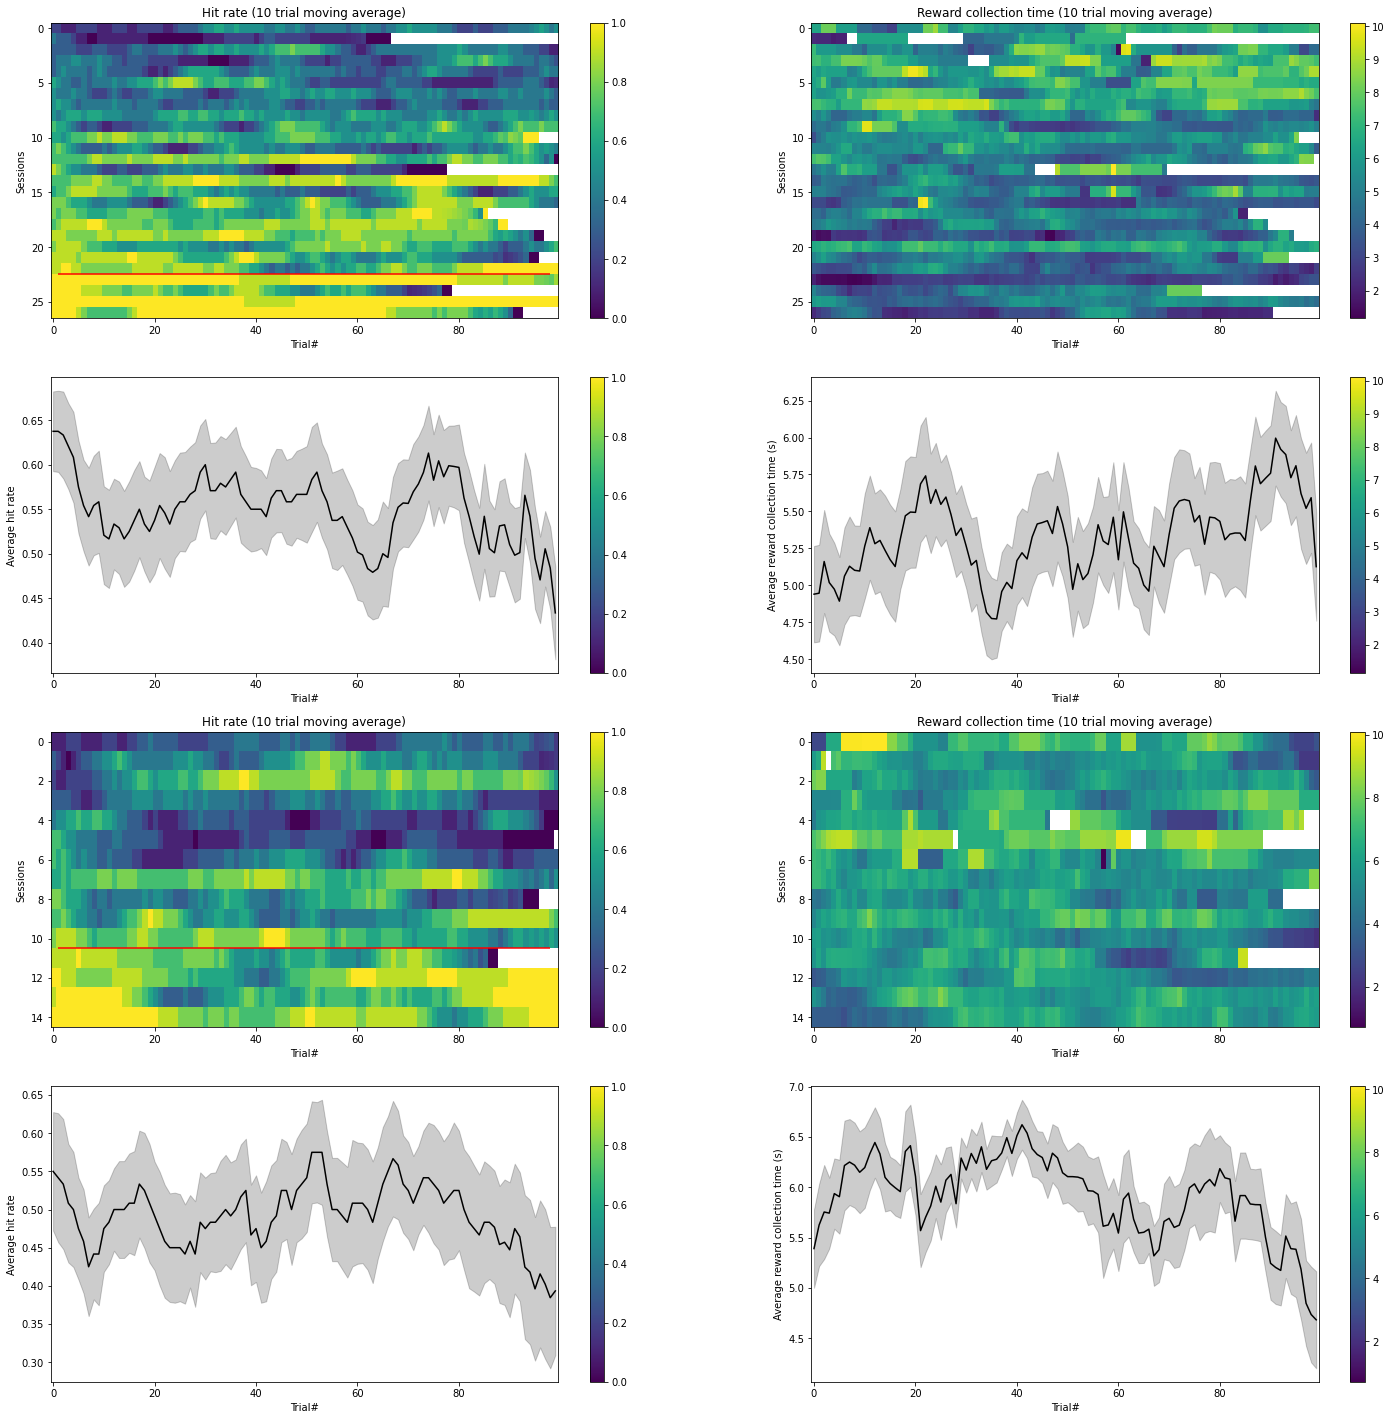

In [195]:
# behavior plot

fig  = plt.figure(figsize = [25,25])
baseline_trial_num = 0 # subtract the average of this many trial
max_reward_rate_start  = .9 # if reward rate is higher than this, skip session from plot


for i in [0,1]:
    if i == 0:
        rewarded_trials_list = rewarded_trials_list_orig[light_session_list_orig == False]
        time_to_reward_list = time_to_reward_list_orig[light_session_list_orig == False]
    else:
        rewarded_trials_list = rewarded_trials_list_orig[light_session_list_orig == True]
        time_to_reward_list = time_to_reward_list_orig[light_session_list_orig == True]
            #plt.plot(movingaverage(data_dict[session][
        

    ax_im_rewrate  = fig.add_subplot(4,2,1+i*4)
    needed = np.nanmean(rewarded_trials_list[:,:10],1)<=max_reward_rate_start
    if baseline_trial_num==0:
        im = ax_im_rewrate.imshow(rewarded_trials_list[:,:],aspect = 'auto', interpolation = 'none') #-np.nanmean(rewarded_trials_list[:,:5],1)[:,np.newaxis]
    else:
        im = ax_im_rewrate.imshow(rewarded_trials_list[:,:]-np.nanmean(rewarded_trials_list[:,:baseline_trial_num],1)[:,np.newaxis],aspect = 'auto', interpolation = 'none') #
    ax_im_rewrate.hlines(np.argmin(needed)-.5,1,rewarded_trials_list.shape[1]-2,color = 'red')
    ax_im_rewrate.set_ylabel('Sessions')
    ax_im_rewrate.set_xlabel('Trial#')
    ax_im_rewrate.set_title('Hit rate ({} trial moving average)'.format(averaging_window))
    fig.colorbar(im, ax=ax_im_rewrate,location = 'right')


    ax_plt_rewrate = fig.add_subplot(4,2,3+i*4,sharex = ax_im_rewrate)
    x = np.arange(rewarded_trials_list.shape[1])
    y = np.nanmean(rewarded_trials_list[needed,:],0)
    yerr = np.nanstd(rewarded_trials_list[needed,:],0)/np.sqrt(sum(needed))
    ax_plt_rewrate.plot(x,y,'k-')

    ax_plt_rewrate.fill_between(x, y-yerr, y+yerr,color = 'black',alpha = .2)
    fig.colorbar(im, ax=ax_plt_rewrate,location = 'right')

    ax_plt_rewrate.set_ylabel('Average hit rate')
    ax_plt_rewrate.set_xlabel('Trial#')


    needed = rewarded_trials_list[:,0]<=max_reward_rate_start+100
    ax_im_rewrtime  = fig.add_subplot(4,2,2+i*4)
    if baseline_trial_num==0:
        im = ax_im_rewrtime.imshow(time_to_reward_list[needed,:],aspect = 'auto', interpolation = 'none') #-np.nanmean(time_to_reward_list[:,:20],1)[:,np.newaxis]
    else:
        im = ax_im_rewrtime.imshow(time_to_reward_list[needed,:]-np.nanmean(time_to_reward_list[needed,:baseline_trial_num],1)[:,np.newaxis],aspect = 'auto', interpolation = 'none') #

    ax_im_rewrtime.set_ylabel('Sessions')
    ax_im_rewrtime.set_xlabel('Trial#')
    ax_im_rewrtime.set_title('Reward collection time ({} trial moving average)'.format(averaging_window))
    fig.colorbar(im, ax=ax_im_rewrtime,location = 'right')


    ax_plt_rewtime = fig.add_subplot(4,2,4+i*4,sharex = ax_im_rewrtime)


    x = np.arange(time_to_reward_list.shape[1])
    y = np.nanmean(time_to_reward_list[:,:],0)
    yerr = np.nanstd(time_to_reward_list[:,:],0)/np.sqrt(len(needed))
    ax_plt_rewtime.plot(x,y,'k-')
    ax_plt_rewtime.fill_between(x, y-yerr, y+yerr,color = 'black',alpha = .2)


    ax_plt_rewtime.set_ylabel('Average reward collection time (s)')
    ax_plt_rewtime.set_xlabel('Trial#')
    fig.colorbar(im, ax=ax_plt_rewtime,location = 'right')

In [203]:
# how does the task tuning of CN change on light and no-light sessions
percentile_increase = []
delta_amplitudes = []
light_dose = []
paAIP_expression = []
session_type = []
previous_tuning = []
current_tuning = []
mean_delta_amplitudes = []
within_session_tuning_changes = []
max_blue_light_dose = []
sparsity = []
previous_session_spont_dff_std = []
previous_session_task_dff_std = []
previous_session_task_dff_std_no_reward = []

previous_session_spont_dff_mean = []
previous_session_task_dff_mean = []
previous_session_task_dff_mean_no_reward = []

previous_session_event_rate= []
previous_session_event_amplitude= []

current_session_rewarded_dff = []
previous_session_rewarded_dff = []


previous_session_task_dff_std_all = []
mean_delta_amplitudes_all = []

previous_session_photon_counts_all = []
previous_session_f0_all = []

previous_session_tuning_all = []
for subject in data_dict_big.keys():
    for fov in data_dict_big[subject].keys():
        sessions = list(data_dict_big[subject][fov].keys())
        FOV_task_tuning_ratio = []
        FOV_reward_tuning = []
        FOV_reward_tuning_ratio = []
        FOV_expression = []
        FOV_blue_light_dose = []
        for session_0,session_1 in zip(sessions[:-1],sessions[1:]):
            cn = np.unique(data_dict_big[subject][fov][session_1]['cn'])
            if len(cn)>1:
                asdasdasdas
            else:
                cn = cn[0]
            if 'ctrl' in data_dict_big[subject][fov][session_1]['training_type']: # ctrl session
                # if 'ctrl' in data_dict_big[subject][fov][session_0]['training_type']: # ctrl session
                #     continue
                session_type.append('ctrl')
            elif 'ctrl' not in data_dict_big[subject][fov][session_1]['training_type']: # light session
                session_type.append('light')
                #print([data_dict_big[subject][fov][session_1]['blue_light_dose'][cn],np.max(data_dict_big[subject][fov][session_1]['blue_light_dose'])])
            
            prev_tuning = data_dict_big[subject][fov][session_0]['trial_averaged_tuning']
            curr_tuning = data_dict_big[subject][fov][session_1]['trial_averaged_tuning']
            
            
            
#             tnh = int(data_dict_big[subject][fov][session_0]['neuron_by_trial_tuning'].shape[1]/2)
#             prev_tuning = np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_tuning'][:,tnh:],1)
    
#             tnh = int(data_dict_big[subject][fov][session_1]['neuron_by_trial_tuning'].shape[1]/2)
#             curr_tuning = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_tuning'][:,tnh:],1)
    
    
            tnh = int(data_dict_big[subject][fov][session_1]['neuron_by_trial_tuning'].shape[1]/2)
            curr_tuning_fh = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_tuning'][:,:tnh],1)
            curr_tuning_sh = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_tuning'][:,tnh:],1)


            delta_amplitudes.append(curr_tuning[cn]-prev_tuning[cn])
            diffFRm = curr_tuning-prev_tuning
            #diffFRm-=np.nanmean(diffFRm)
            spar = 1 -((np.sum(diffFRm**2)/(np.sum(np.abs(diffFRm))**2))**-1/diffFRm.shape[0])
            sparsity.append(spar)
            
            light_dose.append(data_dict_big[subject][fov][session_1]['blue_light_dose'][cn])
            paAIP2_expression_ = np.nanmean([data_dict_big[subject][fov][session_0]['paAIP2_expression']['red_intensity_normalized'],
                                            data_dict_big[subject][fov][session_1]['paAIP2_expression']['red_intensity_normalized']],0) # average of two sessions
            paAIP_expression.append(paAIP2_expression_[cn])
            da =curr_tuning-prev_tuning
            da_cn = da[cn]
            percentile_increase.append(np.where(np.sort(da)==da_cn)[0][0]/len(da))
            previous_tuning.append(prev_tuning[cn])
            current_tuning.append(curr_tuning[cn])
            mean_delta_amplitudes.append(np.nanmean(da))
            within_session_tuning_changes.append((curr_tuning_sh-curr_tuning_fh)[cn])
            max_blue_light_dose.append(np.max(data_dict_big[subject][fov][session_1]['blue_light_dose']))
            
            
            previous_session_spont_dff_std.append(data_dict_big[subject][fov][session_0]['spont_dff_std'][cn])
            previous_session_task_dff_std.append(data_dict_big[subject][fov][session_0]['task_dff_std'][cn])
            previous_session_task_dff_std_no_reward.append(data_dict_big[subject][fov][session_0]['task_dff_std_no_reward'][cn])
            
            previous_session_spont_dff_mean.append(data_dict_big[subject][fov][session_0]['spont_dff_mean'][cn])
            previous_session_task_dff_mean.append(data_dict_big[subject][fov][session_0]['task_dff_mean'][cn])
            previous_session_task_dff_mean_no_reward.append(data_dict_big[subject][fov][session_0]['task_dff_mean_no_reward'][cn])
            
            previous_session_event_rate.append(data_dict_big[subject][fov][session_0]['event_rate'][cn])
            previous_session_event_amplitude.append(data_dict_big[subject][fov][session_0]['amplitude_rate'][cn])
            
            current_session_rewarded_dff.append(np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_pre_reward_amplitude'],1)[cn])
            previous_session_rewarded_dff.append(np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_pre_reward_amplitude'],1)[cn])
            
            previous_session_task_dff_std_all.append(data_dict_big[subject][fov][session_0]['task_dff_std'])
            previous_session_photon_counts_all.append(data_dict_big[subject][fov][session_0]['photon_counts'])
            previous_session_f0_all.append(data_dict_big[subject][fov][session_0]['f0'])
            mean_delta_amplitudes_all.append(da)
            
            previous_session_tuning_all.append(prev_tuning)
            
percentile_increase=np.asarray(percentile_increase)
delta_amplitudes=np.asarray(delta_amplitudes)
light_dose =np.asarray(light_dose)
paAIP_expression =np.asarray(paAIP_expression)
session_type =np.asarray(session_type)
previous_tuning =np.asarray(previous_tuning)
current_tuning =np.asarray(current_tuning)
mean_delta_amplitudes = np.asarray(mean_delta_amplitudes)
within_session_tuning_changes = np.asarray(within_session_tuning_changes)
max_blue_light_dose = np.asarray(max_blue_light_dose)
sparsity = np.asarray(sparsity)
previous_session_spont_dff_std = np.asarray(previous_session_spont_dff_std)
#delta_amplitudes = delta_amplitudes/mean_delta_amplitudes
previous_session_task_dff_std = np.asarray(previous_session_task_dff_std)
previous_session_task_dff_std_no_reward = np.asarray(previous_session_task_dff_std_no_reward)

previous_session_event_amplitude = np.asarray(previous_session_event_amplitude)
previous_session_event_rate = np.asarray(previous_session_event_rate)

previous_session_spont_dff_mean = np.asarray(previous_session_spont_dff_mean)
previous_session_task_dff_mean = np.asarray(previous_session_task_dff_mean)
previous_session_task_dff_mean_no_reward = np.asarray(previous_session_task_dff_mean_no_reward)

current_session_rewarded_dff = np.asarray(current_session_rewarded_dff)
previous_session_rewarded_dff = np.asarray(previous_session_rewarded_dff)

delta_session_rewarded_dff = current_session_rewarded_dff -  previous_session_rewarded_dff

previous_session_task_dff_std_all = np.asarray(previous_session_task_dff_std_all)
mean_delta_amplitudes_all = np.asarray(mean_delta_amplitudes_all)

previous_session_photon_counts_all = np.asarray(previous_session_photon_counts_all)
previous_session_f0_all = np.asarray(previous_session_f0_all)

previous_session_tuning_all = np.asarray(previous_session_tuning_all)

/tmp/ipykernel_30188/1987883407.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  previous_session_task_dff_std_all = np.asarray(previous_session_task_dff_std_all)
/tmp/ipykernel_30188/1987883407.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_delta_amplitudes_all = np.asarray(mean_delta_amplitudes_all)
/tmp/ipykernel_30188/1987883407.py:146: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

In [177]:
data_dict_big[subject][fov][session_1].keys()

dict_keys(['paAIP2_expression', 'blue_light_distribution', 'trial_averaged_tuning', 'neuron_by_trial_tuning', 'neuron_by_trial_reward_amplitude', 'neuron_by_trial_pre_reward_amplitude', 'spont_dff_std', 'spont_dff_mean', 'stat', 'cn', 'mean_image', 'metadata_row', 'rewarded_trials', 'time_to_reward', 'task_dff_std', 'task_dff_mean', 'task_dff_std_no_reward', 'task_dff_mean_no_reward', 'event_rate', 'amplitude_rate', 'f0', 'photon_counts', 'version', 'blue_light_dose', 'duty_cycle', 'training_type'])

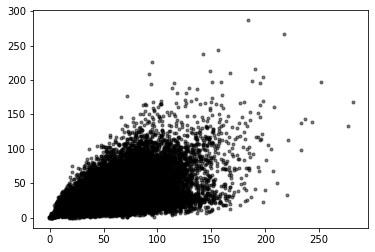

In [198]:
plt.plot(np.concatenate(previous_session_f0_all),np.concatenate(previous_session_photon_counts_all),'k.',alpha = .5)


/tmp/ipykernel_30188/2444996420.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([-0.01,2])


(0.03814897114539385, 2)

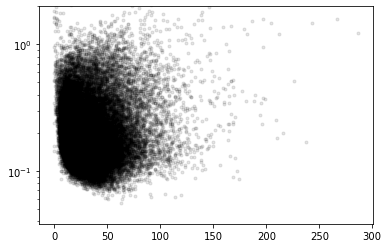

In [201]:
fig = plt
plt.plot(np.concatenate(previous_session_photon_counts_all),np.concatenate(previous_session_task_dff_std_all),'k.',alpha = .1)
plt.yscale('log')
#plt.xlim([-10,50])
plt.ylim([-0.01,2])


'a'

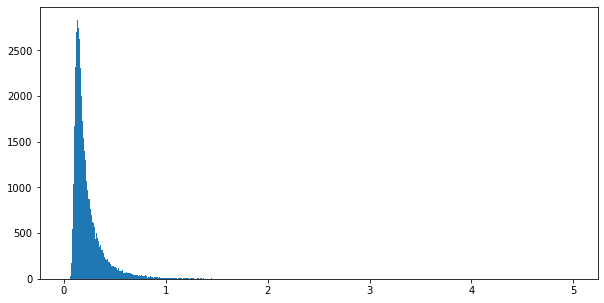

In [220]:
fig = plt.figure(figsize = [10,5])
plt.hist(np.concatenate(previous_session_task_dff_std_all),np.arange(.01,5,.01))
# plt.yscale('log')
# plt.xscale('log')
'a'

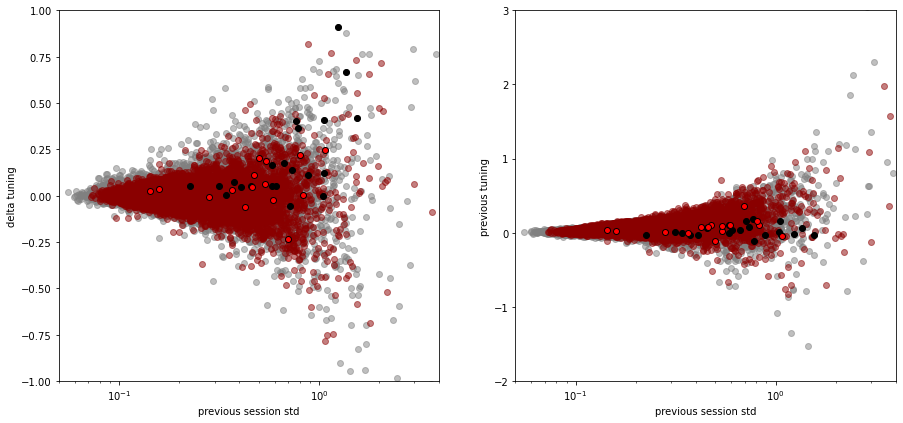

In [224]:
fig = plt.figure(figsize = [15,15])
ax = fig.add_subplot(221)
ax.plot(np.concatenate(previous_session_task_dff_std_all[ctrl_exps]),np.concatenate(mean_delta_amplitudes_all[ctrl_exps]),'o', color = 'grey',alpha = .5)
ax.plot(np.concatenate(previous_session_task_dff_std_all[light_exps]),np.concatenate(mean_delta_amplitudes_all[light_exps]),'o', color = 'darkred',alpha = .5)
ax.plot(previous_session_task_dff_std[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')#,markeredgecolor = 'red',linewidth = .1)
ax.plot(previous_session_task_dff_std[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp',markeredgecolor = 'black',linewidth = .1)
plt.xlim([0.05,4])
plt.ylim([-1,1])
plt.xlabel('previous session std')
plt.ylabel('delta tuning')
plt.xscale('log')

ax = fig.add_subplot(2,2,2)
ax.plot(np.concatenate(previous_session_task_dff_std_all[ctrl_exps]),np.concatenate(previous_session_tuning_all[ctrl_exps]),'o', color = 'grey',alpha = .5)
ax.plot(np.concatenate(previous_session_task_dff_std_all[light_exps]),np.concatenate(previous_session_tuning_all[light_exps]),'o', color = 'darkred',alpha = .5)
ax.plot(previous_session_task_dff_std[ctrl_exps],previous_tuning[ctrl_exps],'ko',label = 'ctrl exp')#,markeredgecolor = 'red',linewidth = .1)
ax.plot(previous_session_task_dff_std[light_exps],previous_tuning[light_exps],'ro',label = 'light exp',markeredgecolor = 'black',linewidth = .1)
plt.xlabel('previous session std')
plt.ylabel('previous tuning')
plt.xlim([0.05,4])
plt.ylim([-2,3])
plt.xscale('log')

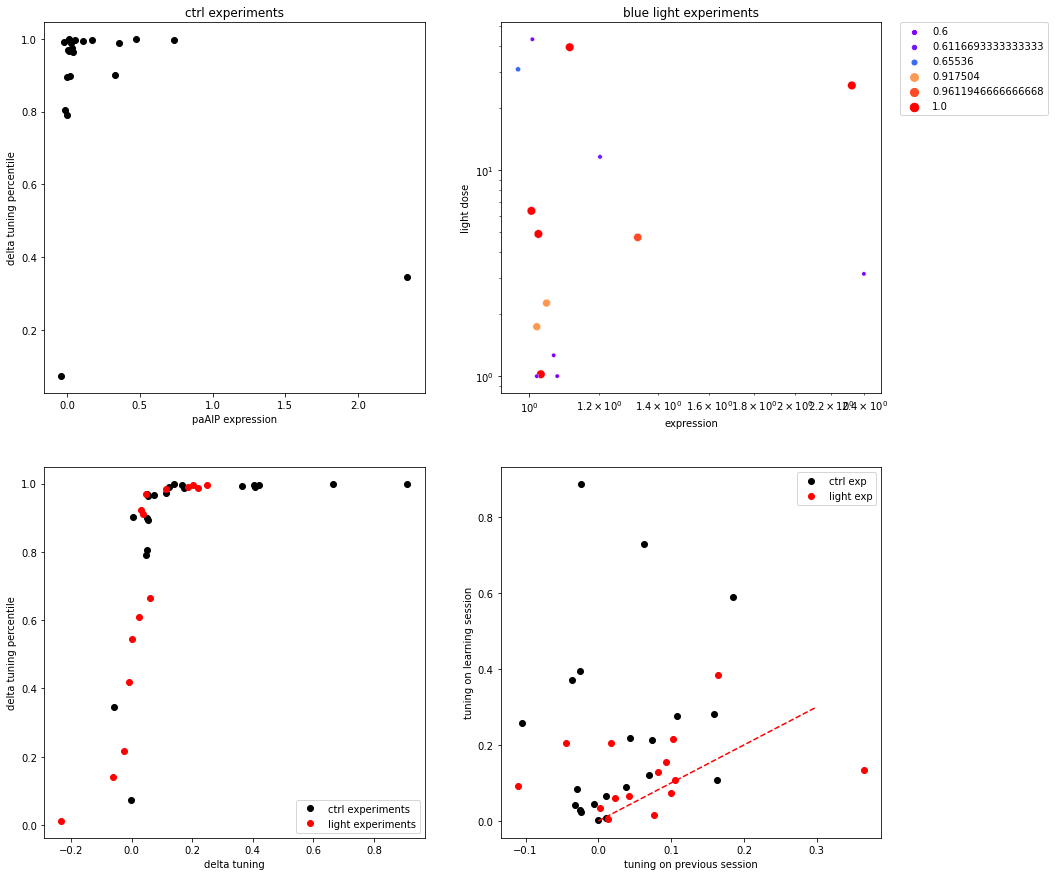

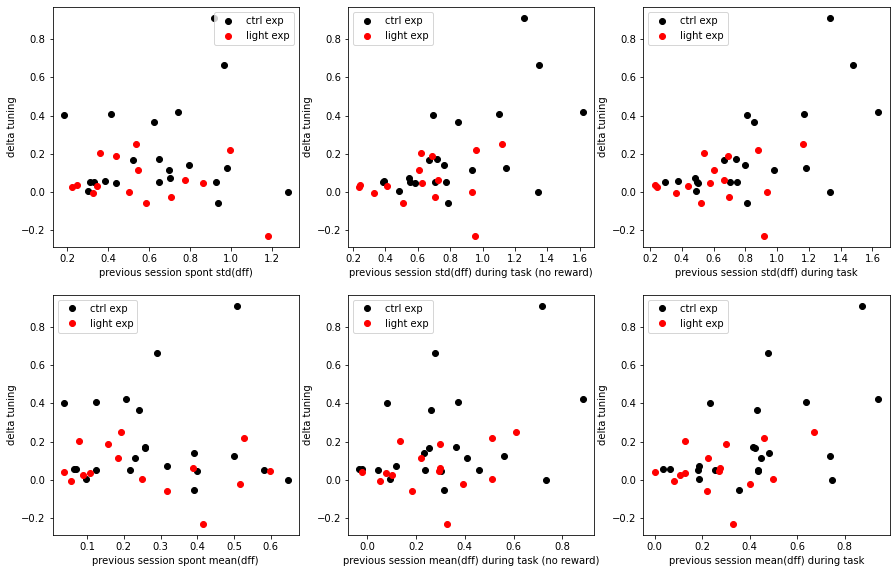

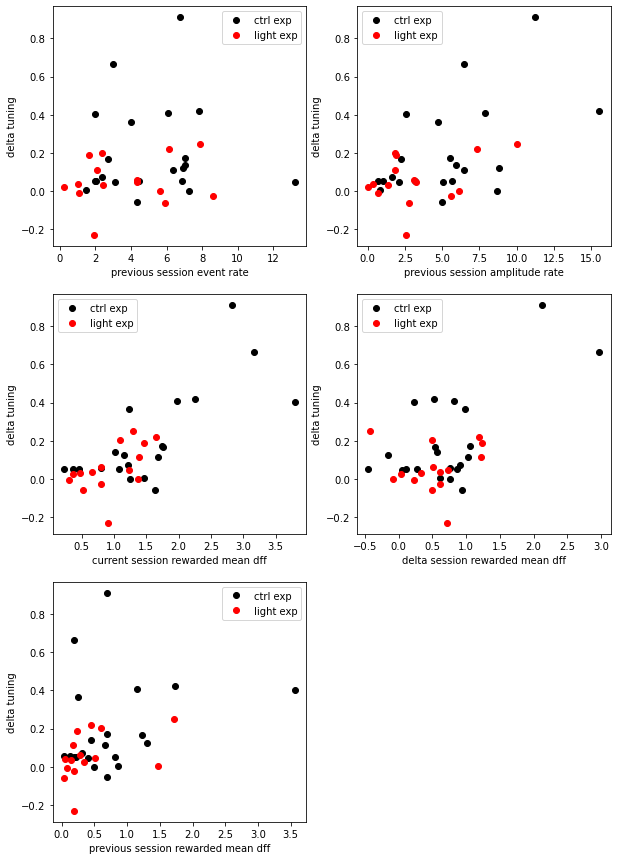

In [138]:
import seaborn as sns
#light_dose = max_blue_light_dose
ctrl_exps = session_type == 'ctrl'

light_exps = session_type == 'light'





fig = plt.figure(figsize = [15,15])


ax_ctrl_exp = fig.add_subplot(2,2,1)
ax_ctrl_exp.set_title('ctrl experiments')
ctrl_exps = session_type == 'ctrl'
ax_ctrl_exp.plot(paAIP_expression[ctrl_exps],percentile_increase[ctrl_exps],'ko') #delta_amplitudes
ax_ctrl_exp.set_xlabel('paAIP expression')
ax_ctrl_exp.set_ylabel('delta tuning percentile')


ax_exp_light = fig.add_subplot(2,2,2)
ax_exp_light.set_title('blue light experiments')



t_ = percentile_increase[light_exps]
t_ = t_[np.isnan(t_)==False]
t_ = t_[np.isnan(t_)==False]
hue_range_  = tuple(np.percentile(t_,[1,99]))#(-.1,.1)#
hue_range_ = (.6,1)
hue_vals = np.arange(5000)
i_ = 200000
while len(np.unique(hue_vals))>10:
    
    hue_vals = np.round((percentile_increase[light_exps])*i_,1)/i_
    i_ =i_/2
while len(np.unique(hue_vals))<10:
    
    hue_vals = np.round((percentile_increase[light_exps])*i_,1)/i_
    i_ =i_*1.5
    #print([i_,len(np.unique(hue_vals))])
hue_vals[hue_vals<hue_range_[0]] = hue_range_[0]
hue_vals[hue_vals>hue_range_[1]] = hue_range_[1]

sns.scatterplot( x=paAIP_expression[light_exps]+1, #distance_from_light_center,#
                y=light_dose[light_exps]+1, 
                hue=hue_vals,
                ax = ax_exp_light,
                hue_norm = hue_range_,
                size = hue_vals,
                #size_norm = hue_range_,
               alpha = 1,
                palette='rainbow',
               legend = 'full')
plt.xscale('log')
plt.yscale('log')

ax_exp_light.set_ylabel('light dose')
ax_exp_light.set_xlabel('expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)



ax_percentile_amplitude = fig.add_subplot(2,2,3)
ax_percentile_amplitude.plot(delta_amplitudes[ctrl_exps],percentile_increase[ctrl_exps],'ko',label = 'ctrl experiments')
ax_percentile_amplitude.plot(delta_amplitudes[light_exps],percentile_increase[light_exps],'ro',label = 'light experiments')
ax_percentile_amplitude.legend()
ax_percentile_amplitude.set_xlabel('delta tuning')
ax_percentile_amplitude.set_ylabel('delta tuning percentile')

ax_prev_current_tuning = fig.add_subplot(2,2,4)
ax_prev_current_tuning.plot(previous_tuning[ctrl_exps],current_tuning[ctrl_exps],'ko',label = 'ctrl exp')
ax_prev_current_tuning.plot(previous_tuning[light_exps],current_tuning[light_exps],'ro',label = 'light exp')
ax_prev_current_tuning.plot([0,.3],[0,.3],'r--')
ax_prev_current_tuning.set_xlabel('tuning on previous session')
ax_prev_current_tuning.set_ylabel('tuning on learning session')
ax_prev_current_tuning.legend()

fig = plt.figure(figsize = [15,15])

ax = fig.add_subplot(3,3,1)
ax.plot(previous_session_spont_dff_std[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_spont_dff_std[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session spont std(dff)')
ax.set_ylabel('delta tuning')
ax.legend()

ax = fig.add_subplot(3,3,2)
ax.plot(previous_session_task_dff_std_no_reward[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_task_dff_std_no_reward[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session std(dff) during task (no reward)')
ax.set_ylabel('delta tuning')
ax.legend()

ax = fig.add_subplot(3,3,3)
ax.plot(previous_session_task_dff_std[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_task_dff_std[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session std(dff) during task')
ax.set_ylabel('delta tuning')
ax.legend()



ax = fig.add_subplot(3,3,4)
ax.plot(previous_session_spont_dff_mean[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_spont_dff_mean[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session spont mean(dff)')
ax.set_ylabel('delta tuning')
ax.legend()

ax = fig.add_subplot(3,3,5)
ax.plot(previous_session_task_dff_mean_no_reward[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_task_dff_mean_no_reward[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session mean(dff) during task (no reward)')
ax.set_ylabel('delta tuning')
ax.legend()

ax = fig.add_subplot(3,3,6)
ax.plot(previous_session_task_dff_mean[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_task_dff_mean[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session mean(dff) during task')
ax.set_ylabel('delta tuning')
ax.legend()



fig = plt.figure(figsize = [10,15])
ax = fig.add_subplot(321)
ax.plot(previous_session_event_rate[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_event_rate[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session event rate')
ax.set_ylabel('delta tuning')
ax.legend()


ax = fig.add_subplot(322)
ax.plot(previous_session_event_amplitude[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_event_amplitude[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session amplitude rate')
ax.set_ylabel('delta tuning')
ax.legend()


ax = fig.add_subplot(323)
ax.plot(current_session_rewarded_dff[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(current_session_rewarded_dff[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('current session rewarded mean dff')
ax.set_ylabel('delta tuning')
ax.legend()

ax = fig.add_subplot(324)
ax.plot(delta_session_rewarded_dff[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(delta_session_rewarded_dff[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('delta session rewarded mean dff')
ax.set_ylabel('delta tuning')
ax.legend()

ax = fig.add_subplot(325)
ax.plot(previous_session_rewarded_dff[ctrl_exps],delta_amplitudes[ctrl_exps],'ko',label = 'ctrl exp')
ax.plot(previous_session_rewarded_dff[light_exps],delta_amplitudes[light_exps],'ro',label = 'light exp')
ax.set_xlabel('previous session rewarded mean dff')
ax.set_ylabel('delta tuning')
ax.legend()
#current_session_rewarded_dff
# ax_spar = fig.add_subplot(2,2,2)
# ax_spar.plot(previous_tuning[ctrl_exps],sparsity[ctrl_exps],'ko',label = 'ctrl exp')
# ax_spar.plot(previous_tuning[light_exps],sparsity[light_exps],'ro',label = 'light exp')
# ax_spar.set_xlabel('previous tuning')
# ax_spar.set_ylabel('sparsity')
# ax_spar.legend()
# r = scipy.stats.pearsonr(previous_tuning,sparsity)
# ax_spar.set_title('r: {:.3f} - p: {:.3f}'.format(r[0],r[1]))


(-0.004878236818811528, 0.28639645289600246)


Text(0.5, 0, 'paAIP expression')

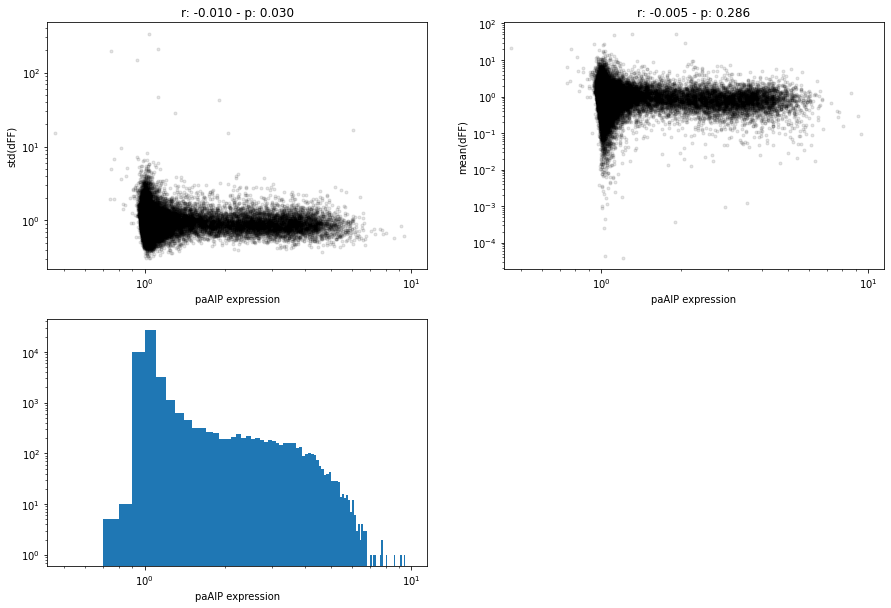

In [62]:
# look how paAIP expression affects spontaneous activity and tuning
import scipy
spont_std_list = []
spont_mean_list = []
red_exp_list = []
for subject in data_dict_big.keys():
    for fov in data_dict_big[subject].keys():
        sessions = list(data_dict_big[subject][fov].keys())
        for session in sessions:
            spont_std_list.append(data_dict_big[subject][fov][session]['spont_dff_std'])#/np.mean(data_dict_big[subject][fov][session]['spont_dff_std'])
            spont_mean_list.append(data_dict_big[subject][fov][session]['spont_dff_mean'])#/np.mean(data_dict_big[subject][fov][session]['spont_dff_mean'])
            red_exp_list.append(data_dict_big[subject][fov][session]['paAIP2_expression']['red_intensity_normalized'])
red_exp_list = np.concatenate(red_exp_list)
spont_std_list = np.concatenate(spont_std_list)
spont_mean_list = np.concatenate(spont_mean_list)
fig = plt.figure(figsize = [15,10])
ax_std = fig.add_subplot(2,2,1)
ax_std.plot(red_exp_list+1,spont_std_list,'k.',alpha = .1)
#ax_std.set_ylim([0,6])#np.percentile(spont_std_list,[1,99]))
ax_std.set_xlabel('paAIP expression')
ax_std.set_ylabel('std(dFF)')
ax_std.set_xscale('log')
ax_std.set_yscale('log')
r = scipy.stats.pearsonr(red_exp_list,spont_std_list)
ax_std.set_title('r: {:.3f} - p: {:.3f}'.format(r[0],r[1]))


ax_mean = fig.add_subplot(2,2,2,sharex = ax_std)
ax_mean.plot(red_exp_list+1,spont_mean_list,'k.',alpha = .1)

#ax_mean.set_ylim([0,6])#np.percentile(spont_std_list,[1,99]))
ax_mean.set_xlabel('paAIP expression')
ax_mean.set_ylabel('mean(dFF)')
ax_mean.set_xscale('log')
ax_mean.set_yscale('log')
r = scipy.stats.pearsonr(red_exp_list,spont_mean_list)
print(r)
ax_mean.set_title('r: {:.3f} - p: {:.3f}'.format(r[0],r[1]))

ax_exp = fig.add_subplot(2,2,3,sharex = ax_std)
ax_exp.hist(red_exp_list+1,np.arange(.5,10,.1))
ax_exp.set_xscale('log')
ax_exp.set_yscale('log')
ax_exp.set_xlabel('paAIP expression')

In [34]:
# compare reward and task tuning for subsequent light off and light on sessions

ratio_edges = [-1,1]
task_tuning_ratio_all = []
task_paAIP2_expression_all = []
task_blue_ligt_dose_all = []
reward_tuning_ratio_all = []
reward_paAIP2_expression_all = []
reward_blue_ligt_dose_all = []
comparison = 'subtract'#'divide'
for subject in data_dict_big.keys():
    for fov in data_dict_big[subject].keys():
        sessions = list(data_dict_big[subject][fov].keys())
        FOV_task_tuning_ratio = []
        FOV_reward_tuning = []
        FOV_reward_tuning_ratio = []
        FOV_expression = []
        FOV_blue_light_dose = []
        for session_0,session_1 in zip(sessions[:-1],sessions[1:]):
            FOV_reward_tuning.append(np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_reward_amplitude'],1))
            if 'ctrl' in data_dict_big[subject][fov][session_0]['training_type'] and 'ctrl' not in data_dict_big[subject][fov][session_1]['training_type']:
                #continue
                reward_tuning_ctrl = np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_reward_amplitude'],1)
                reward_tuning_light = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_reward_amplitude'],1)
                blue_light_dose = data_dict_big[subject][fov][session_1]['blue_light_dose']
                task_tuning_ctrl = data_dict_big[subject][fov][session_0]['trial_averaged_tuning']
                task_tuning_light = data_dict_big[subject][fov][session_1]['trial_averaged_tuning']
            elif 'ctrl' in data_dict_big[subject][fov][session_1]['training_type'] and 'ctrl' not in data_dict_big[subject][fov][session_0]['training_type']:
                #continue
                reward_tuning_light = np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_reward_amplitude'],1)
                reward_tuning_ctrl = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_reward_amplitude'],1)
                blue_light_dose = data_dict_big[subject][fov][session_0]['blue_light_dose']
                task_tuning_light = data_dict_big[subject][fov][session_0]['trial_averaged_tuning']
                task_tuning_ctrl = data_dict_big[subject][fov][session_1]['trial_averaged_tuning']
            # elif 'ctrl' in data_dict_big[subject][fov][session_1]['training_type'] and 'ctrl'  in data_dict_big[subject][fov][session_0]['training_type']:
            #     reward_tuning_light = np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_reward_amplitude'],1)
            #     reward_tuning_ctrl = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_reward_amplitude'],1)
            #     blue_light_dose = data_dict_big[subject][fov][session_0]['blue_light_dose']
            #     task_tuning_light = data_dict_big[subject][fov][session_0]['trial_averaged_tuning']
            #     task_tuning_ctrl = data_dict_big[subject][fov][session_1]['trial_averaged_tuning']
            else:
                continue
            paAIP2_expression = np.nanmean([data_dict_big[subject][fov][session_0]['paAIP2_expression']['red_intensity_normalized'],
                                            data_dict_big[subject][fov][session_1]['paAIP2_expression']['red_intensity_normalized']],0) # average of two sessions
            
            FOV_expression.append(paAIP2_expression)
            FOV_blue_light_dose.append(blue_light_dose)
            if comparison == 'subtract':#'divide'
                FOV_reward_tuning_ratio.append(reward_tuning_light-reward_tuning_ctrl)
                FOV_task_tuning_ratio.append(task_tuning_light-task_tuning_ctrl)
            elif comparison == 'divide':
                FOV_reward_tuning_ratio.append(reward_tuning_light/reward_tuning_ctrl)
                FOV_task_tuning_ratio.append(task_tuning_light/task_tuning_ctrl)
                #'divide'
        if len(FOV_reward_tuning_ratio)==0:
            continue
        FOV_reward_tuning.append(np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_reward_amplitude'],1))
        
        FOV_reward_tuning_ratio = np.asarray(FOV_reward_tuning_ratio)
        FOV_task_tuning_ratio = np.asarray(FOV_task_tuning_ratio)
        FOV_reward_tuning = np.asarray(FOV_reward_tuning)
        FOV_expression = np.asarray(FOV_expression)
        FOV_blue_light_dose = np.asarray(FOV_blue_light_dose)
        
        
        mean_reward_tuning = np.nanmean(np.asarray(FOV_reward_tuning),0)
        tuned_cells = mean_reward_tuning>-np.inf#np.nanstd(mean_reward_tuning)*0+np.nanmean(mean_reward_tuning)   
        
        reward_tuning_ratio_all.append(FOV_reward_tuning_ratio[:,tuned_cells].flatten())
        reward_paAIP2_expression_all.append(FOV_expression[:,tuned_cells].flatten())
        reward_blue_ligt_dose_all.append(FOV_blue_light_dose[:,tuned_cells].flatten())
        
        task_tuning_ratio_all.append(FOV_task_tuning_ratio.flatten())
        task_paAIP2_expression_all.append(FOV_expression.flatten())
        task_blue_ligt_dose_all.append(FOV_blue_light_dose.flatten())
        
        #asd
reward_tuning_ratio_all = np.concatenate(reward_tuning_ratio_all)
reward_paAIP2_expression_all = np.concatenate(reward_paAIP2_expression_all)
reward_blue_ligt_dose_all = np.concatenate(reward_blue_ligt_dose_all)
task_tuning_ratio_all = np.concatenate(task_tuning_ratio_all)
task_paAIP2_expression_all = np.concatenate(task_paAIP2_expression_all)
task_blue_ligt_dose_all = np.concatenate(task_blue_ligt_dose_all)
reward_tuning_ratio_all[reward_tuning_ratio_all<ratio_edges[0]] = ratio_edges[0]
reward_tuning_ratio_all[reward_tuning_ratio_all>ratio_edges[1]] = ratio_edges[1]
task_tuning_ratio_all[task_tuning_ratio_all<ratio_edges[0]] = ratio_edges[0]
task_tuning_ratio_all[task_tuning_ratio_all>ratio_edges[1]] = ratio_edges[1]

Text(0.5, 1.0, 'change in tuning')

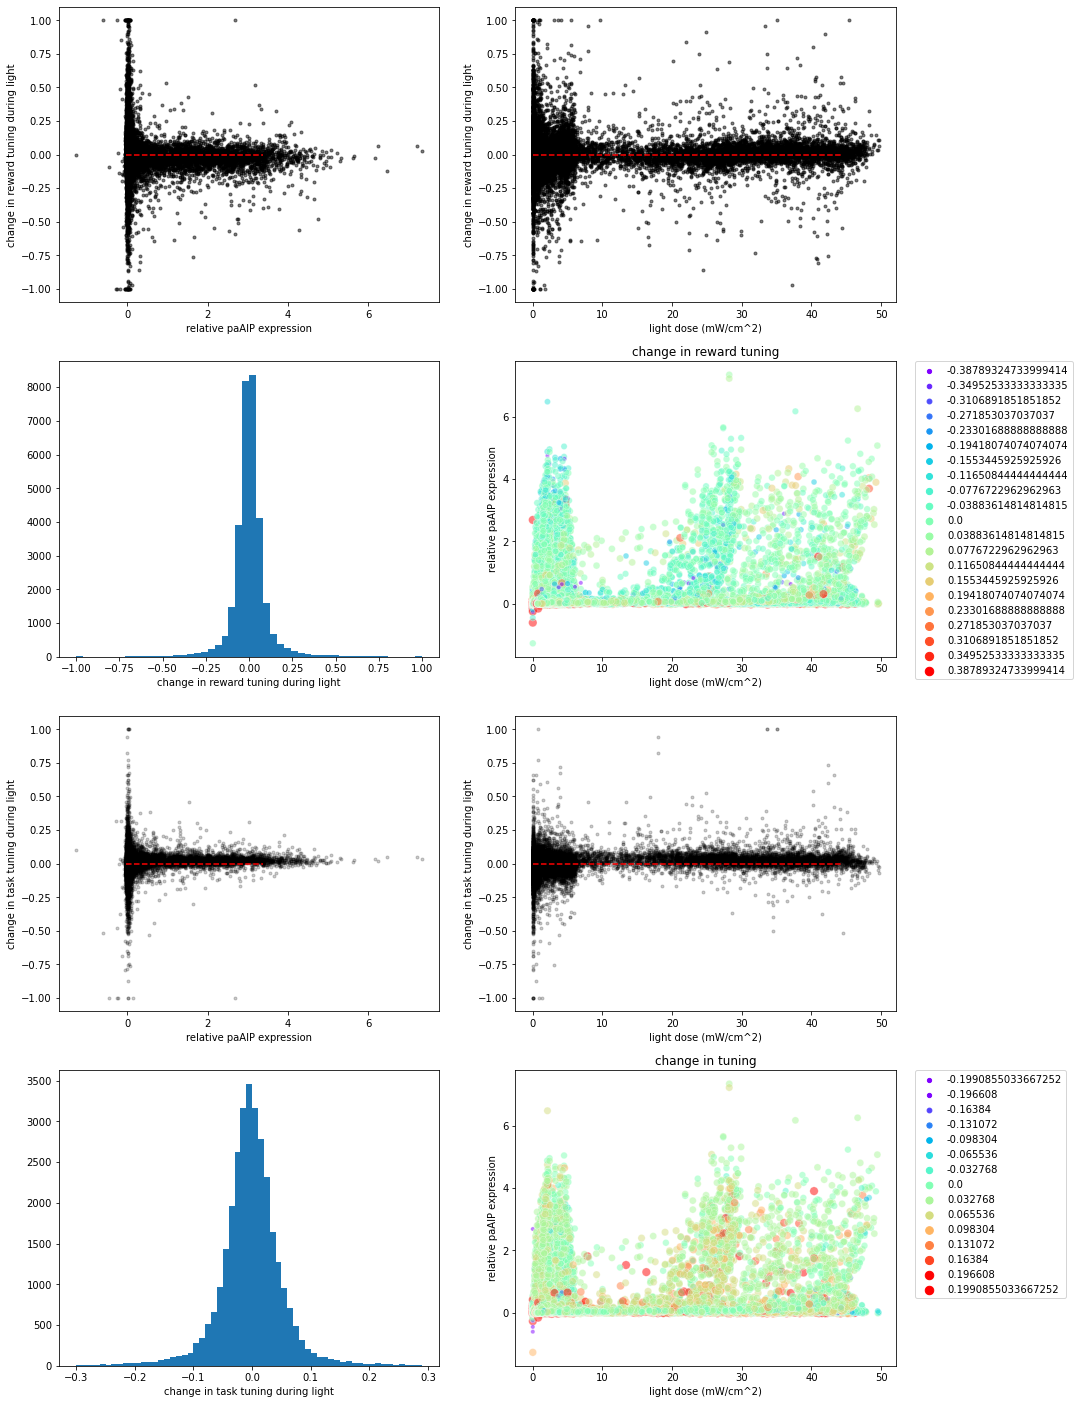

In [35]:
# how does blue light change reward and task tuning

import seaborn as sns
fig = plt.figure(figsize = [15,25])
ax_exp = fig.add_subplot(4,2,1)
ax_exp.plot(reward_paAIP2_expression_all,reward_tuning_ratio_all,'k.',alpha = .5)
ax_exp.plot(np.percentile(reward_paAIP2_expression_all,[1,99]),[0,0],'r--')
ax_exp.set_xlabel('relative paAIP expression')
ax_exp.set_ylabel('change in reward tuning during light')

ax_light = fig.add_subplot(4,2,2)
ax_light.plot(reward_blue_ligt_dose_all,reward_tuning_ratio_all,'k.',alpha = .5)
ax_light.plot(np.percentile(reward_blue_ligt_dose_all,[1,99]),[0,0],'r--')
ax_light.set_xlabel('light dose (mW/cm^2)')
ax_light.set_ylabel('change in reward tuning during light')

ax_reward_tuning_change_dist = fig.add_subplot(4,2,3)
ax_reward_tuning_change_dist.hist(reward_tuning_ratio_all,50)
ax_reward_tuning_change_dist.set_xlabel('change in reward tuning during light')


ax_exp_light = fig.add_subplot(4,2,4)
#ax_exp_light.plot(reward_paAIP2_expression_all,reward_blue_ligt_dose_all,'k.',alpha = .5)


t_ = reward_tuning_ratio_all
t_ = t_[np.isnan(t_)==False]
t_ = t_[np.isnan(t_)==False]
hue_range_  = tuple(np.percentile(t_,[1,99]))#(-.1,.1)#
hue_range_  = (-1*np.max(np.abs(hue_range_)),np.max(np.abs(hue_range_)))
hue_vals = np.arange(5000)
i_ = 200000
while len(np.unique(hue_vals))>50:
    hue_vals = np.round((reward_tuning_ratio_all)*i_,1)/i_
    i_ =i_/2
while len(np.unique(hue_vals))<50:
    
    hue_vals = np.round((reward_tuning_ratio_all)*i_,1)/i_
    i_ =i_*1.5
    #print([i_,len(np.unique(hue_vals))])
hue_vals[hue_vals<hue_range_[0]] = hue_range_[0]
hue_vals[hue_vals>hue_range_[1]] = hue_range_[1]

sns.scatterplot( x=reward_blue_ligt_dose_all, #distance_from_light_center,#
                y=reward_paAIP2_expression_all, 
                hue=hue_vals,
                ax = ax_exp_light,
                hue_norm = hue_range_,
                size = hue_vals,
                size_norm = hue_range_,
               alpha = .5,
                palette='rainbow',
               legend = 'full')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#ax_exp_light.plot(task_paAIP2_expression_all,task_blue_ligt_dose_all,'k.',alpha = .2)
ax_exp_light.set_ylabel('relative paAIP expression')
ax_exp_light.set_xlabel('light dose (mW/cm^2)')
ax_exp_light.set_title('change in reward tuning')



ax_exp = fig.add_subplot(4,2,5)
ax_exp.plot(task_paAIP2_expression_all,task_tuning_ratio_all,'k.',alpha = .2)
ax_exp.set_xlabel('relative paAIP expression')
ax_exp.set_ylabel('change in task tuning during light')
ax_exp.plot(np.percentile(task_paAIP2_expression_all,[1,99]),[0,0],'r--')

ax_light = fig.add_subplot(4,2,6)
ax_light.plot(task_blue_ligt_dose_all,task_tuning_ratio_all,'k.',alpha = .2)
ax_light.set_xlabel('light dose (mW/cm^2)')
ax_light.set_ylabel('change in task tuning during light')
ax_light.plot(np.percentile(task_blue_ligt_dose_all,[1,99]),[0,0],'r--')

ax_reward_tuning_change_dist = fig.add_subplot(4,2,7)
ax_reward_tuning_change_dist.hist(task_tuning_ratio_all,np.arange(-.3,.3,.01))
ax_reward_tuning_change_dist.set_xlabel('change in task tuning during light')


ax_exp_light = fig.add_subplot(4,2,8)

t_ = task_tuning_ratio_all
t_ = t_[np.isnan(t_)==False]
t_ = t_[np.isnan(t_)==False]
hue_range_  = tuple(np.percentile(t_,[1,99]))#(-.1,.1)#
#hue_range_ = (-.1,.1)
hue_range_  = (-1*np.max(np.abs(hue_range_)),np.max(np.abs(hue_range_)))
hue_vals = np.arange(5000)
i_ = 200000
while len(np.unique(hue_vals))>50:
    
    hue_vals = np.round((task_tuning_ratio_all)*i_,1)/i_
    i_ =i_/2
while len(np.unique(hue_vals))<50:
    
    hue_vals = np.round((task_tuning_ratio_all)*i_,1)/i_
    i_ =i_*1.5
    #print([i_,len(np.unique(hue_vals))])
hue_vals[hue_vals<hue_range_[0]] = hue_range_[0]
hue_vals[hue_vals>hue_range_[1]] = hue_range_[1]

sns.scatterplot( x=task_blue_ligt_dose_all, #distance_from_light_center,#
                y=task_paAIP2_expression_all, 
                hue=hue_vals,
                ax = ax_exp_light,
                #hue_norm = hue_range_,
                size = hue_vals,
                #size_norm = hue_range_,
               alpha = .5,
                palette='rainbow',
               legend = 'full')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#ax_exp_light.plot(task_paAIP2_expression_all,task_blue_ligt_dose_all,'k.',alpha = .2)
ax_exp_light.set_ylabel('relative paAIP expression')
ax_exp_light.set_xlabel('light dose (mW/cm^2)')
ax_exp_light.set_title('change in tuning')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


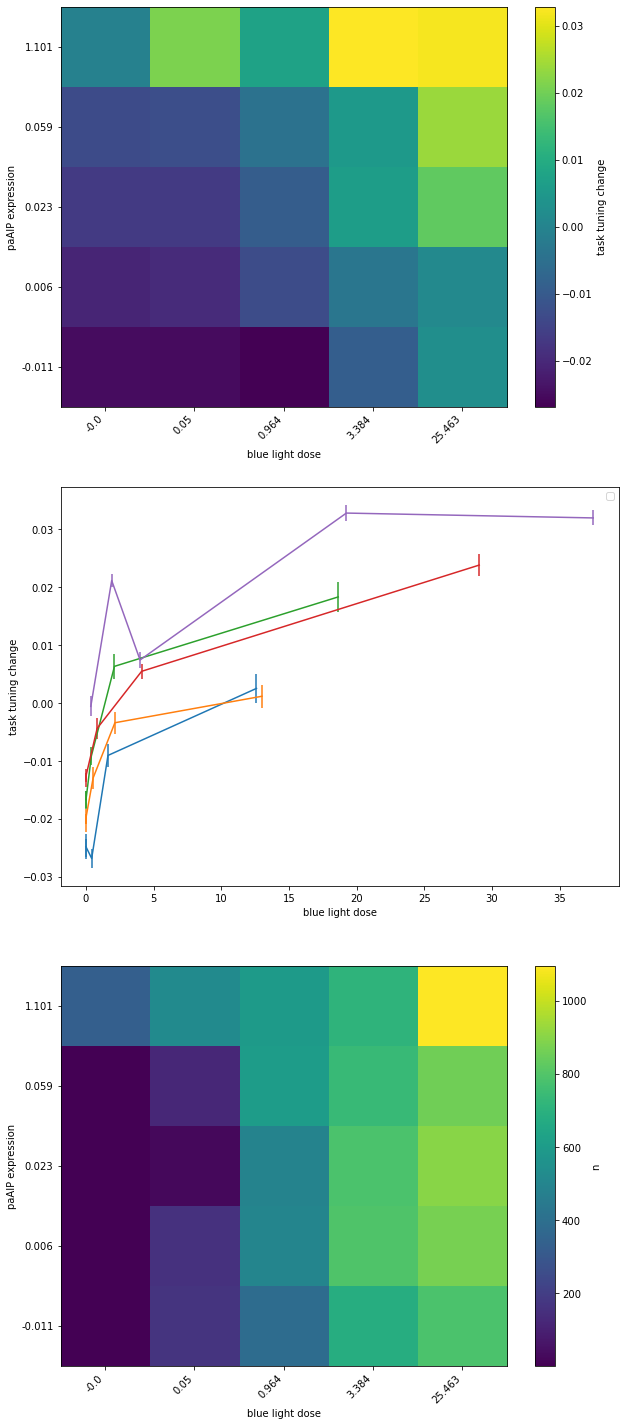

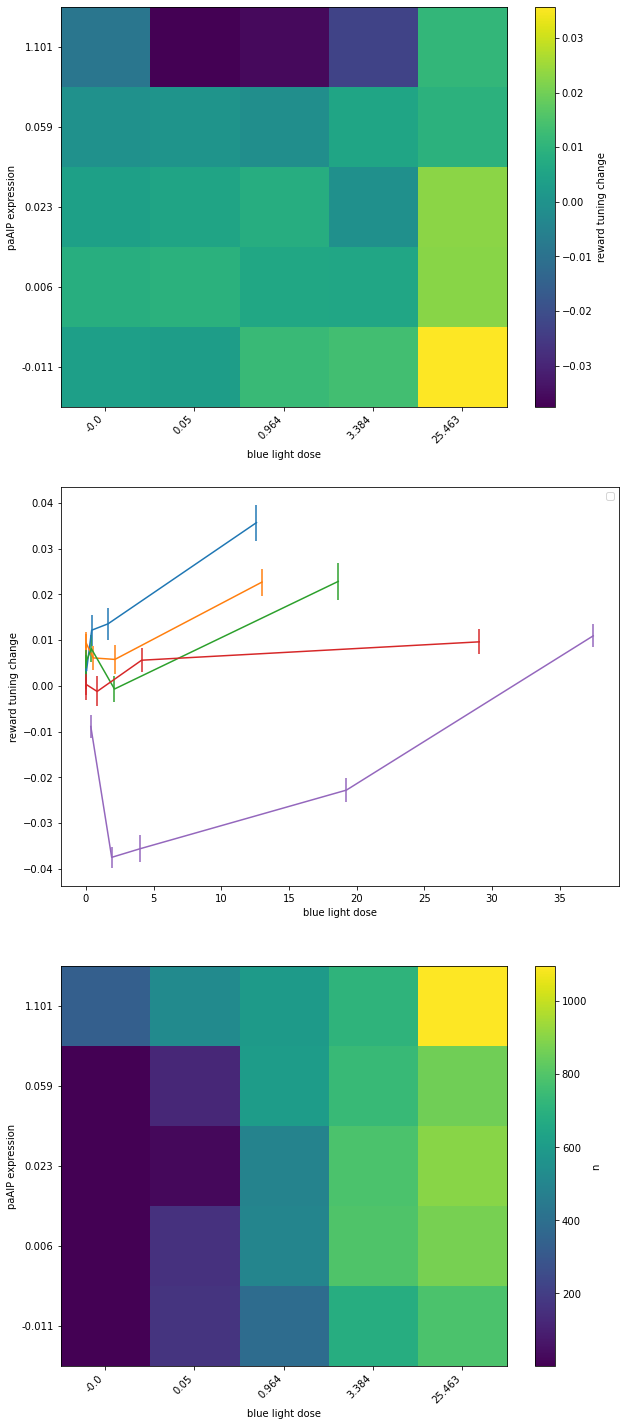

In [185]:
# how does blue light change reward and task tuning - heatmap
def generate_heatmap(x_list_all = task_blue_ligt_dose_all,
                    y_base_list_all = task_paAIP2_expression_all,
                    y_list_all = task_tuning_ratio_all,
                    ylabel = 'task tuning change',
                    xlabel = 'blue light dose',
                    third_axis_label = 'paAIP expression',
                    bin_num_y  = 5,
                    bin_num_x = 5,
                    equalize_bin_n = False):

    


    x_sorted = np.sort(x_list_all)

    x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
    x_ends = x_starts[1:]
    x_starts = x_starts[:-1]

    x_values_plotted = []
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
        x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))

    y_base_sorted = np.sort(y_base_list_all)
    y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
    y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
    y_ends = y_starts[1:]
    y_starts = y_starts[:-1]

    bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
    y_base_values= []
    x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
    error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
    n_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
    for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
        needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
        y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
        x_list = x_list_all[needed_indices]
        y_list = y_list_all[needed_indices]

        if equalize_bin_n:
            x_sorted = np.sort(x_list)
            x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num_x)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]   


        for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
            needed_indices = (x_list>=x_s)&(x_list<=x_e)
            n = sum(needed_indices)
            bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
            x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
            error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)
            n_matrix[xi,yi] = len(np.unique(x_list[needed_indices]))



    fig = plt.figure(figsize = [10,25])
    ax = fig.add_subplot(3,1,1)
    im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
    ax.set_yticks(np.arange(bin_num_y))
    ax.set_yticklabels(np.round(y_base_values,3))
    ax.set_xticks(np.arange(bin_num_x))
    ax.set_xticklabels(np.round(x_values_plotted,3))
    ax.set_ylabel(third_axis_label)
    ax.set_xlabel(xlabel)
    plt.xticks(rotation=45, ha='right')
    fig.colorbar(im,ax = ax,label = ylabel)

    ax = fig.add_subplot(3,1,2)
    for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
        ax.errorbar(x,y,err)#,label = l)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend()

    ax = fig.add_subplot(3,1,3)
    im = ax.imshow(n_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
    ax.set_yticks(np.arange(bin_num_y))
    ax.set_yticklabels(np.round(y_base_values,3))
    ax.set_xticks(np.arange(bin_num_x))
    ax.set_xticklabels(np.round(x_values_plotted,3))
    ax.set_ylabel(third_axis_label)
    ax.set_xlabel(xlabel)
    plt.xticks(rotation=45, ha='right')
    fig.colorbar(im,ax = ax,label = 'n')
    
    
x_list_all = task_blue_ligt_dose_all
y_base_list_all = task_paAIP2_expression_all
y_list_all = task_tuning_ratio_all
ylabel = 'task tuning change'
xlabel = 'blue light dose'
third_axis_label = 'paAIP expression'

generate_heatmap(x_list_all = task_blue_ligt_dose_all,
                    y_base_list_all = task_paAIP2_expression_all,
                    y_list_all = task_tuning_ratio_all,
                    ylabel = 'task tuning change',
                    xlabel = 'blue light dose',
                    third_axis_label = 'paAIP expression',
                    bin_num_y  = 5,
                    bin_num_x = 5,
                    equalize_bin_n = False)

generate_heatmap(x_list_all = reward_blue_ligt_dose_all,
                    y_base_list_all = reward_paAIP2_expression_all,
                    y_list_all = reward_tuning_ratio_all,
                    ylabel = 'reward tuning change',
                    xlabel = 'blue light dose',
                    third_axis_label = 'paAIP expression',
                    bin_num_y  = 5,
                    bin_num_x = 5,
                    equalize_bin_n = False)

In [186]:
# can a light session erase tuning for the NEXT session?

ratio_edges = [-1,1]
task_tuning_ratio_all = []
task_paAIP2_expression_all = []
task_blue_ligt_dose_all = []
reward_tuning_ratio_all = []
reward_paAIP2_expression_all = []
reward_blue_ligt_dose_all = []
comparison = 'subtract'#'divide'
for subject in data_dict_big.keys():
    for fov in data_dict_big[subject].keys():
        sessions = list(data_dict_big[subject][fov].keys())
        FOV_task_tuning_ratio = []
        FOV_reward_tuning = []
        FOV_reward_tuning_ratio = []
        FOV_expression = []
        FOV_blue_light_dose = []
        for session_0,session_1 in zip(sessions[:-1],sessions[1:]):
            FOV_reward_tuning.append(np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_reward_amplitude'],1))
            if 'ctrl' in data_dict_big[subject][fov][session_0]['training_type'] and 'ctrl' not in data_dict_big[subject][fov][session_1]['training_type']:
                continue
                reward_tuning_ctrl = np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_reward_amplitude'],1)
                reward_tuning_light = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_reward_amplitude'],1)
                blue_light_dose = data_dict_big[subject][fov][session_1]['blue_light_dose']
                task_tuning_ctrl = data_dict_big[subject][fov][session_0]['trial_averaged_tuning']
                task_tuning_light = data_dict_big[subject][fov][session_1]['trial_averaged_tuning']
            elif 'ctrl' in data_dict_big[subject][fov][session_1]['training_type'] and 'ctrl' not in data_dict_big[subject][fov][session_0]['training_type']:
                #continue
                reward_tuning_light = np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_reward_amplitude'],1)
                reward_tuning_ctrl = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_reward_amplitude'],1)
                blue_light_dose = data_dict_big[subject][fov][session_0]['blue_light_dose']
                task_tuning_light = data_dict_big[subject][fov][session_0]['trial_averaged_tuning']
                task_tuning_ctrl = data_dict_big[subject][fov][session_1]['trial_averaged_tuning']
            # elif 'ctrl' in data_dict_big[subject][fov][session_1]['training_type'] and 'ctrl'  in data_dict_big[subject][fov][session_0]['training_type']:
            #     reward_tuning_light = np.nanmean(data_dict_big[subject][fov][session_0]['neuron_by_trial_reward_amplitude'],1)
            #     reward_tuning_ctrl = np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_reward_amplitude'],1)
            #     blue_light_dose = data_dict_big[subject][fov][session_0]['blue_light_dose']
            #     task_tuning_light = data_dict_big[subject][fov][session_0]['trial_averaged_tuning']
            #     task_tuning_ctrl = data_dict_big[subject][fov][session_1]['trial_averaged_tuning']
            else:
                continue
            paAIP2_expression = np.nanmean([data_dict_big[subject][fov][session_0]['paAIP2_expression']['red_intensity_normalized'],
                                            data_dict_big[subject][fov][session_1]['paAIP2_expression']['red_intensity_normalized']],0) # average of two sessions
            
            FOV_expression.append(paAIP2_expression)
            FOV_blue_light_dose.append(blue_light_dose)
            if comparison == 'subtract':#'divide'
                FOV_reward_tuning_ratio.append(reward_tuning_ctrl-reward_tuning_light)
                FOV_task_tuning_ratio.append(task_tuning_ctrl-task_tuning_light)
            elif comparison == 'divide':
                FOV_reward_tuning_ratio.append(reward_tuning_ctrl/reward_tuning_light)
                FOV_task_tuning_ratio.append(task_tuning_ctrl/task_tuning_light)
                #'divide'
        if len(FOV_reward_tuning_ratio)==0:
            continue
        FOV_reward_tuning.append(np.nanmean(data_dict_big[subject][fov][session_1]['neuron_by_trial_reward_amplitude'],1))
        
        FOV_reward_tuning_ratio = np.asarray(FOV_reward_tuning_ratio)
        FOV_task_tuning_ratio = np.asarray(FOV_task_tuning_ratio)
        FOV_reward_tuning = np.asarray(FOV_reward_tuning)
        FOV_expression = np.asarray(FOV_expression)
        FOV_blue_light_dose = np.asarray(FOV_blue_light_dose)
        
        
        mean_reward_tuning = np.nanmean(np.asarray(FOV_reward_tuning),0)
        tuned_cells = mean_reward_tuning>-np.inf#np.nanstd(mean_reward_tuning)*0+np.nanmean(mean_reward_tuning)   
        
        reward_tuning_ratio_all.append(FOV_reward_tuning_ratio[:,tuned_cells].flatten())
        reward_paAIP2_expression_all.append(FOV_expression[:,tuned_cells].flatten())
        reward_blue_ligt_dose_all.append(FOV_blue_light_dose[:,tuned_cells].flatten())
        
        task_tuning_ratio_all.append(FOV_task_tuning_ratio.flatten())
        task_paAIP2_expression_all.append(FOV_expression.flatten())
        task_blue_ligt_dose_all.append(FOV_blue_light_dose.flatten())
        
        #asd
reward_tuning_ratio_all = np.concatenate(reward_tuning_ratio_all)
reward_paAIP2_expression_all = np.concatenate(reward_paAIP2_expression_all)
reward_blue_ligt_dose_all = np.concatenate(reward_blue_ligt_dose_all)
task_tuning_ratio_all = np.concatenate(task_tuning_ratio_all)
task_paAIP2_expression_all = np.concatenate(task_paAIP2_expression_all)
task_blue_ligt_dose_all = np.concatenate(task_blue_ligt_dose_all)
reward_tuning_ratio_all[reward_tuning_ratio_all<ratio_edges[0]] = ratio_edges[0]
reward_tuning_ratio_all[reward_tuning_ratio_all>ratio_edges[1]] = ratio_edges[1]
task_tuning_ratio_all[task_tuning_ratio_all<ratio_edges[0]] = ratio_edges[0]
task_tuning_ratio_all[task_tuning_ratio_all>ratio_edges[1]] = ratio_edges[1]

Text(0.5, 1.0, 'change in tuning')

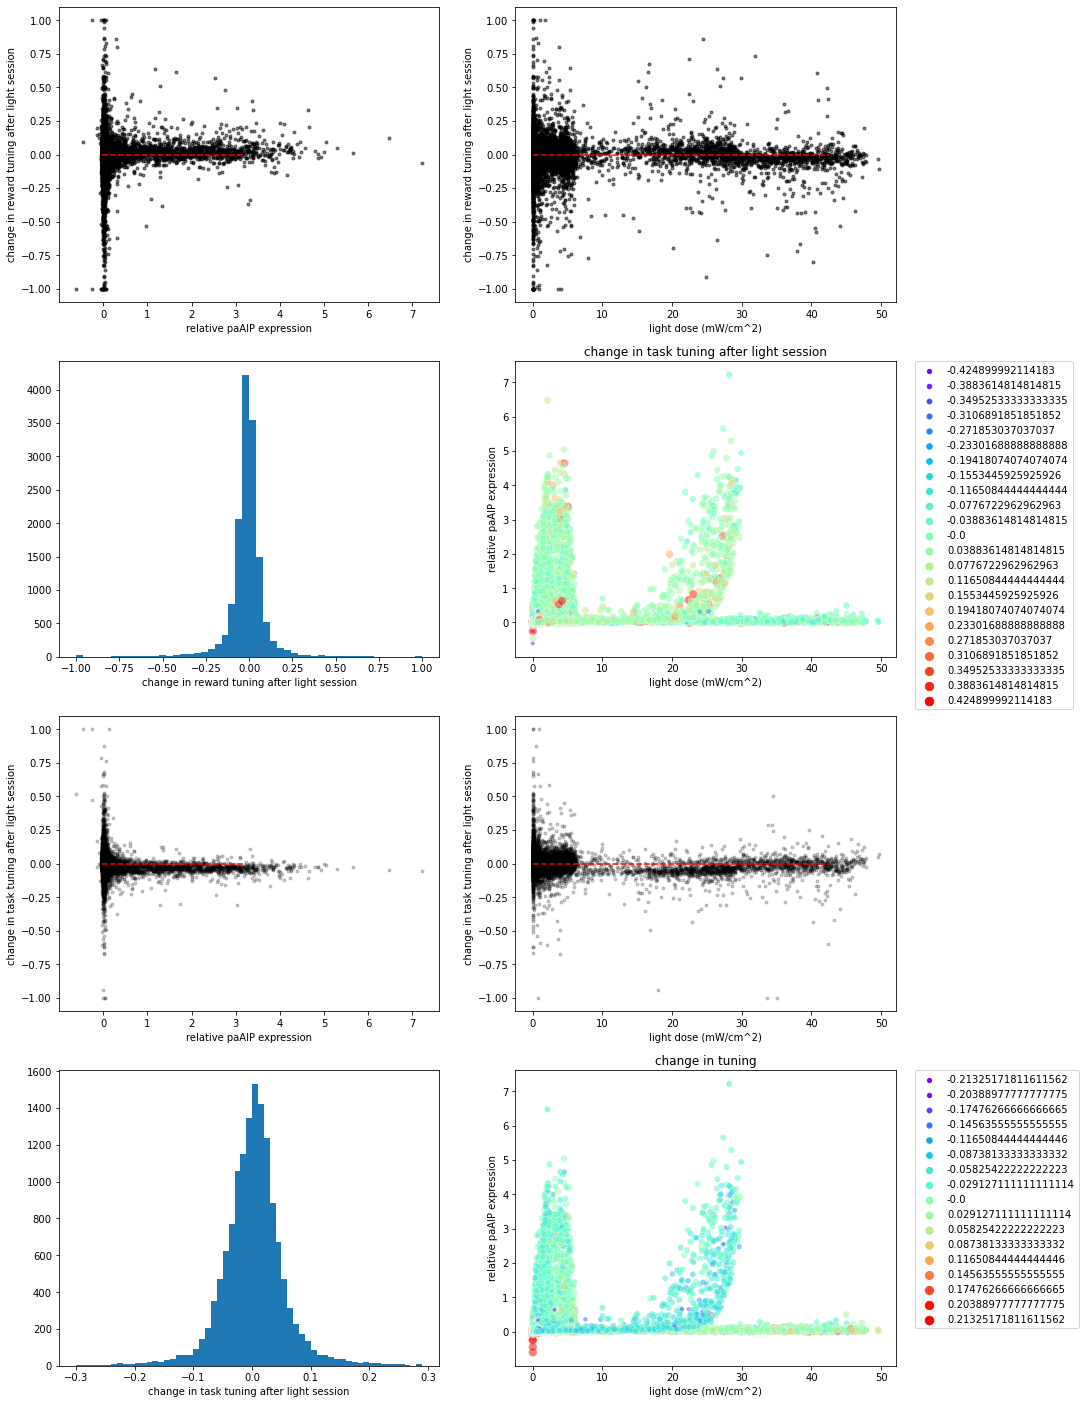

In [187]:
# how does blue light change reward and task tuning

import seaborn as sns
fig = plt.figure(figsize = [15,25])
ax_exp = fig.add_subplot(4,2,1)
ax_exp.plot(reward_paAIP2_expression_all,reward_tuning_ratio_all,'k.',alpha = .5)
ax_exp.plot(np.percentile(reward_paAIP2_expression_all,[1,99]),[0,0],'r--')
ax_exp.set_xlabel('relative paAIP expression')
ax_exp.set_ylabel('change in reward tuning after light session')

ax_light = fig.add_subplot(4,2,2)
ax_light.plot(reward_blue_ligt_dose_all,reward_tuning_ratio_all,'k.',alpha = .5)
ax_light.plot(np.percentile(reward_blue_ligt_dose_all,[1,99]),[0,0],'r--')
ax_light.set_xlabel('light dose (mW/cm^2)')
ax_light.set_ylabel('change in reward tuning after light session')

ax_reward_tuning_change_dist = fig.add_subplot(4,2,3)
ax_reward_tuning_change_dist.hist(reward_tuning_ratio_all,50)
ax_reward_tuning_change_dist.set_xlabel('change in reward tuning after light session')


ax_exp_light = fig.add_subplot(4,2,4)
#ax_exp_light.plot(reward_paAIP2_expression_all,reward_blue_ligt_dose_all,'k.',alpha = .5)


t_ = reward_tuning_ratio_all
t_ = t_[np.isnan(t_)==False]
t_ = t_[np.isnan(t_)==False]
hue_range_  = tuple(np.percentile(t_,[1,99]))#(-.1,.1)#
hue_range_  = (-1*np.max(np.abs(hue_range_)),np.max(np.abs(hue_range_)))
hue_vals = np.arange(5000)
i_ = 200000
while len(np.unique(hue_vals))>50:
    hue_vals = np.round((reward_tuning_ratio_all)*i_,1)/i_
    i_ =i_/2
while len(np.unique(hue_vals))<50:
    
    hue_vals = np.round((reward_tuning_ratio_all)*i_,1)/i_
    i_ =i_*1.5
    #print([i_,len(np.unique(hue_vals))])
hue_vals[hue_vals<hue_range_[0]] = hue_range_[0]
hue_vals[hue_vals>hue_range_[1]] = hue_range_[1]

sns.scatterplot( x=reward_blue_ligt_dose_all, #distance_from_light_center,#
                y=reward_paAIP2_expression_all, 
                hue=hue_vals,
                ax = ax_exp_light,
                hue_norm = hue_range_,
                size = hue_vals,
                size_norm = hue_range_,
               alpha = .5,
                palette='rainbow',
               legend = 'full')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#ax_exp_light.plot(task_paAIP2_expression_all,task_blue_ligt_dose_all,'k.',alpha = .2)
ax_exp_light.set_ylabel('relative paAIP expression')
ax_exp_light.set_xlabel('light dose (mW/cm^2)')
ax_exp_light.set_title('change in task tuning after light session')



ax_exp = fig.add_subplot(4,2,5)
ax_exp.plot(task_paAIP2_expression_all,task_tuning_ratio_all,'k.',alpha = .2)
ax_exp.set_xlabel('relative paAIP expression')
ax_exp.set_ylabel('change in task tuning after light session')
ax_exp.plot(np.percentile(task_paAIP2_expression_all,[1,99]),[0,0],'r--')

ax_light = fig.add_subplot(4,2,6)
ax_light.plot(task_blue_ligt_dose_all,task_tuning_ratio_all,'k.',alpha = .2)
ax_light.set_xlabel('light dose (mW/cm^2)')
ax_light.set_ylabel('change in task tuning after light session')
ax_light.plot(np.percentile(task_blue_ligt_dose_all,[1,99]),[0,0],'r--')

ax_reward_tuning_change_dist = fig.add_subplot(4,2,7)
ax_reward_tuning_change_dist.hist(task_tuning_ratio_all,np.arange(-.3,.3,.01))
ax_reward_tuning_change_dist.set_xlabel('change in task tuning after light session')


ax_exp_light = fig.add_subplot(4,2,8)

t_ = task_tuning_ratio_all
t_ = t_[np.isnan(t_)==False]
t_ = t_[np.isnan(t_)==False]
hue_range_  = tuple(np.percentile(t_,[1,99]))#(-.1,.1)#
#hue_range_ = (-.1,.1)
hue_range_  = (-1*np.max(np.abs(hue_range_)),np.max(np.abs(hue_range_)))
hue_vals = np.arange(5000)
i_ = 200000
while len(np.unique(hue_vals))>50:
    
    hue_vals = np.round((task_tuning_ratio_all)*i_,1)/i_
    i_ =i_/2
while len(np.unique(hue_vals))<50:
    
    hue_vals = np.round((task_tuning_ratio_all)*i_,1)/i_
    i_ =i_*1.5
    #print([i_,len(np.unique(hue_vals))])
hue_vals[hue_vals<hue_range_[0]] = hue_range_[0]
hue_vals[hue_vals>hue_range_[1]] = hue_range_[1]

sns.scatterplot( x=task_blue_ligt_dose_all, #distance_from_light_center,#
                y=task_paAIP2_expression_all, 
                hue=hue_vals,
                ax = ax_exp_light,
                #hue_norm = hue_range_,
                size = hue_vals,
                #size_norm = hue_range_,
               alpha = .5,
                palette='rainbow',
               legend = 'full')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#ax_exp_light.plot(task_paAIP2_expression_all,task_blue_ligt_dose_all,'k.',alpha = .2)
ax_exp_light.set_ylabel('relative paAIP expression')
ax_exp_light.set_xlabel('light dose (mW/cm^2)')
ax_exp_light.set_title('change in tuning')

### 

In [2]:
from rastermap import Rastermap
import scipy
model = Rastermap(n_components=2, n_X=50, nPC=100, init='pca')
a = scipy.stats.zscore(data_dict[session]['dff_sessionwise'],1)
model.fit(a)


#im_events = ax.imshow(events_zscore[model.isort,:],aspect = 'auto', interpolation = 'none')  

nmin 100
0.29870009422302246
7.314893960952759
7.504754304885864
7.510336875915527
(2400, 2500)
(80,)
1.0
time; iteration;  explained PC variance
0.93s     0        0.2002      8
2.77s    10        0.4257      24
4.62s    20        0.5173      80
6.49s    30        0.6534      360
8.74s    40        0.7443      840
10.71s    50        0.8135      1520
12.81s    60        0.8859      2400
14.94s    70        0.8865      2400
16.86s   final      0.8865
25.68s upsampled    0.8865


In [45]:
data_dict_big.keys()

dict_keys(['BCI_59', 'BCI_60'])

In [70]:
#Add to master dict 
#data_dict_big = {}
data_dict_big[subject] = data_dict.copy()
data_dict_big[subject].keys()

dict_keys(['092523', '092623', '092723', '092823', '092923'])

BCI_59
BCI_60
BCI_58


In [208]:
data_dict_big[subject][session]['session_comment']

'original task - return to previous CN in the beginning'

In [70]:
#### calculate behavioral stuff.

is_it_previous_cn = False
if is_it_previous_cn:
    extra_txt = '_previous_CN'
else:
    extra_txt = ''
def movingaverage(DFF,win,function = 'mean'):
    taper = np.ones(win)*np.nan
    DFF = np.concatenate([DFF,taper])
    dff_list = []
    for i in range(win):
        dff_list.append(np.roll(DFF,i*-1,axis = 0))
    if function == 'mean':
        DFF_averaged = np.nanmean(np.asarray(dff_list),0).squeeze()
    elif function == 'median':
        DFF_averaged = np.nanmedian(np.asarray(dff_list),0).squeeze()
    DFF_averaged = DFF_averaged[:-win]
    return DFF_averaged


needed_comments = ['original']#['anti','pair']#['pair']
excluded_comments = []#['anti']

trials_needed = 100
averaging_window = 10
rewarded_trials_list = []
time_to_reward_list = []
for subject in data_dict_big.keys():
    print(subject)
    
    sessions = data_dict_big[subject].keys()
    for session in sessions:
        #print(data_dict_big[subject][session]['session_comment'])
        session_is_needed =True
        for c in needed_comments:
            session_is_needed = session_is_needed and c in data_dict_big[subject][session]['session_comment']
        for c in excluded_comments:
            session_is_needed = session_is_needed and c not in data_dict_big[subject][session]['session_comment']
        #print([data_dict_big[subject][session]['session_comment'],session_is_needed])
        if not session_is_needed:
            continue
        print(session)
        try:
            rewarded_trials_now = data_dict_big[subject][session]['rewarded_trials'+extra_txt]
            if averaging_window>1:
                rewarded_trials_now = movingaverage(rewarded_trials_now,averaging_window)
            rewarded_trials_now_ = np.ones(trials_needed)*np.nan
            rewarded_trials_now_[:min([len(rewarded_trials_now),len(rewarded_trials_now_)])] = rewarded_trials_now[:min([len(rewarded_trials_now),len(rewarded_trials_now_)])]
            rewarded_trials_list.append(rewarded_trials_now_)

            time_to_reward_now = data_dict_big[subject][session]['time_to_reward'+extra_txt]
            if averaging_window>1:
                time_to_reward_now = movingaverage(time_to_reward_now,averaging_window,function = 'mean')
            time_to_reward_now_ = np.ones(trials_needed)*np.nan
            time_to_reward_now_[:min([len(time_to_reward_now),len(time_to_reward_now_)])] = time_to_reward_now[:min([len(time_to_reward_now),len(time_to_reward_now_)])]
            time_to_reward_list.append(time_to_reward_now_)
        except:
            pass
        #asda
        
        
rewarded_trials_list = np.asarray(rewarded_trials_list)
time_to_reward_list = np.asarray(time_to_reward_list)

order = np.argsort(np.nanmean(rewarded_trials_list[:,:5],1)) #np.nanmean(rewarded_trials_list[:,30:60],1)-
rewarded_trials_list = rewarded_trials_list[order,:]
time_to_reward_list = time_to_reward_list[order,:]

    
    #plt.plot(movingaverage(data_dict[session]['rewarded_trials'],5))
    

BCI_59
070323
070523
070623
070723
BCI_60
070323
070523
070623
070723
071023
071123
071223
071323
BCI_58
070323
070523
070623
070723
071023
071123
071223
071323


/tmp/ipykernel_32069/435318682.py:15: RuntimeWarning: Mean of empty slice
  DFF_averaged = np.nanmean(np.asarray(dff_list),0).squeeze()


In [197]:
rewarded_trials_list

array([], dtype=float64)

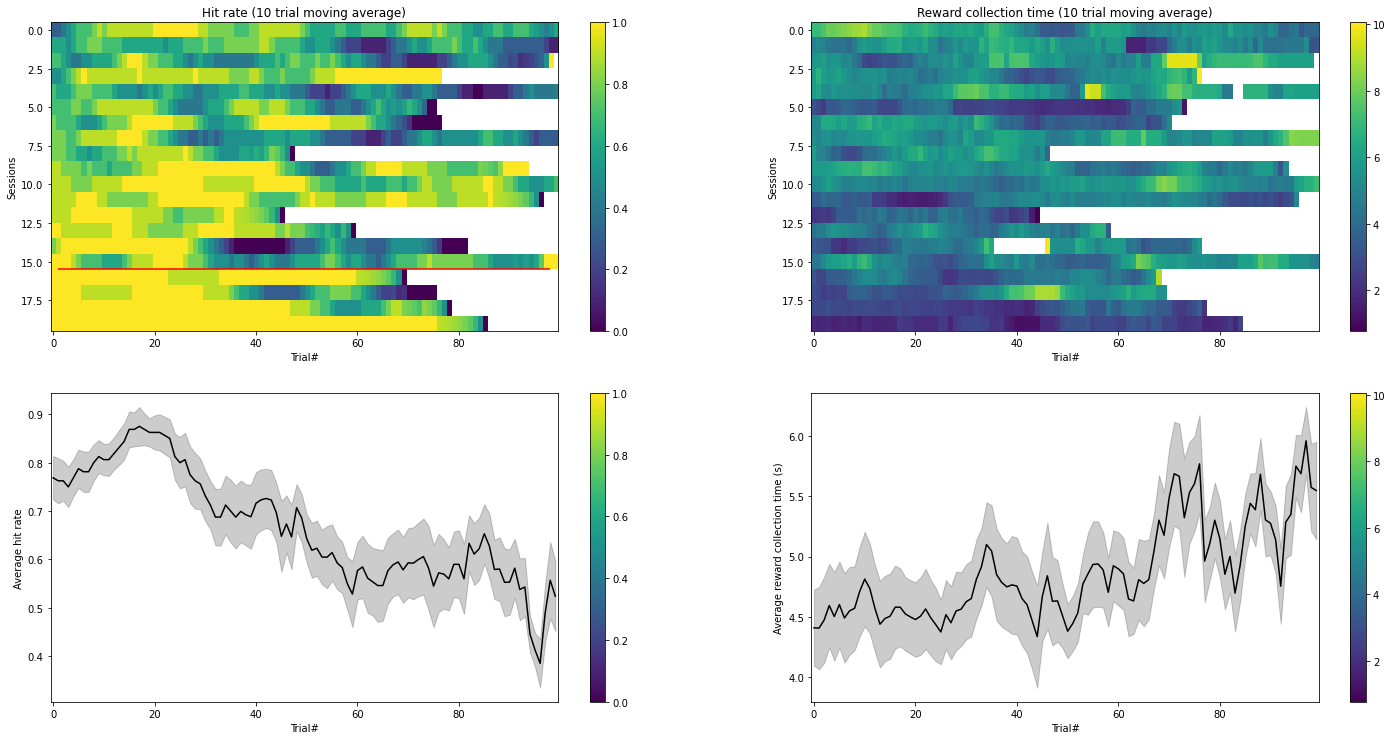

In [71]:
# behavior plot

fig  = plt.figure(figsize = [25,12.5])
baseline_trial_num = 0 # subtract the average of this many trial
max_reward_rate_start  = .99 # if reward rate is higher than this, skip session from plot


ax_im_rewrate  = fig.add_subplot(2,2,1)
needed = np.nanmean(rewarded_trials_list[:,:5],1)<=max_reward_rate_start
if baseline_trial_num==0:
    im = ax_im_rewrate.imshow(rewarded_trials_list[:,:],aspect = 'auto', interpolation = 'none') #-np.nanmean(rewarded_trials_list[:,:5],1)[:,np.newaxis]
else:
    im = ax_im_rewrate.imshow(rewarded_trials_list[:,:]-np.nanmean(rewarded_trials_list[:,:baseline_trial_num],1)[:,np.newaxis],aspect = 'auto', interpolation = 'none') #
ax_im_rewrate.hlines(np.argmin(needed)-.5,1,rewarded_trials_list.shape[1]-2,color = 'red')
ax_im_rewrate.set_ylabel('Sessions')
ax_im_rewrate.set_xlabel('Trial#')
ax_im_rewrate.set_title('Hit rate ({} trial moving average)'.format(averaging_window))
fig.colorbar(im, ax=ax_im_rewrate,location = 'right')


ax_plt_rewrate = fig.add_subplot(2,2,3,sharex = ax_im_rewrate)
x = np.arange(rewarded_trials_list.shape[1])
y = np.nanmean(rewarded_trials_list[needed,:],0)
yerr = np.nanstd(rewarded_trials_list[needed,:],0)/np.sqrt(sum(needed))
ax_plt_rewrate.plot(x,y,'k-')

ax_plt_rewrate.fill_between(x, y-yerr, y+yerr,color = 'black',alpha = .2)
fig.colorbar(im, ax=ax_plt_rewrate,location = 'right')

ax_plt_rewrate.set_ylabel('Average hit rate')
ax_plt_rewrate.set_xlabel('Trial#')


needed = rewarded_trials_list[:,0]<=max_reward_rate_start+100
ax_im_rewrtime  = fig.add_subplot(2,2,2)
if baseline_trial_num==0:
    im = ax_im_rewrtime.imshow(time_to_reward_list[needed,:],aspect = 'auto', interpolation = 'none') #-np.nanmean(time_to_reward_list[:,:20],1)[:,np.newaxis]
else:
    im = ax_im_rewrtime.imshow(time_to_reward_list[needed,:]-np.nanmean(time_to_reward_list[needed,:baseline_trial_num],1)[:,np.newaxis],aspect = 'auto', interpolation = 'none') #

ax_im_rewrtime.set_ylabel('Sessions')
ax_im_rewrtime.set_xlabel('Trial#')
ax_im_rewrtime.set_title('Reward collection time ({} trial moving average)'.format(averaging_window))
fig.colorbar(im, ax=ax_im_rewrtime,location = 'right')
    
    
ax_plt_rewtime = fig.add_subplot(2,2,4,sharex = ax_im_rewrtime)


x = np.arange(time_to_reward_list.shape[1])
y = np.nanmean(time_to_reward_list[:,:],0)
yerr = np.nanstd(time_to_reward_list[:,:],0)/np.sqrt(len(needed))
ax_plt_rewtime.plot(x,y,'k-')
ax_plt_rewtime.fill_between(x, y-yerr, y+yerr,color = 'black',alpha = .2)


ax_plt_rewtime.set_ylabel('Average reward collection time (s)')
ax_plt_rewtime.set_xlabel('Trial#')
fig.colorbar(im, ax=ax_plt_rewtime,location = 'right')